
### Entrada
- x1: Local da Coleta em km
- x2: Nivel da Mare em m
- x3: Umidade do Ar (%)
- x4: Índice Pluvimétrico (mm)¹
- x5: Temperatura (°C)

### Saida
- y1: pH
- y2: Condutividade Elétrica (mS.cmˉ¹)
- y3: Oxigênio Dissolvido (mg.Lˉ¹)
- y4: Sólidos Totais Dissolvidos (ppm)


In [1]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl

In [2]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

/tmp/ipykernel_2631808/989867417.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


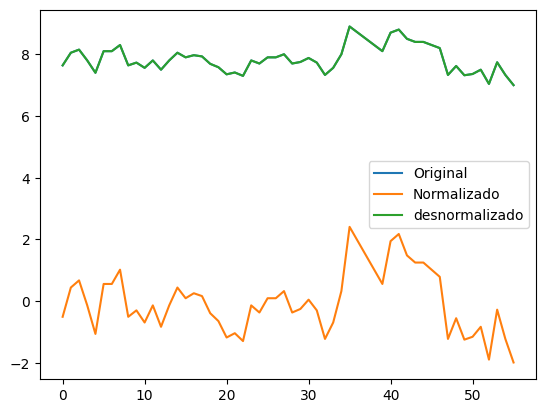

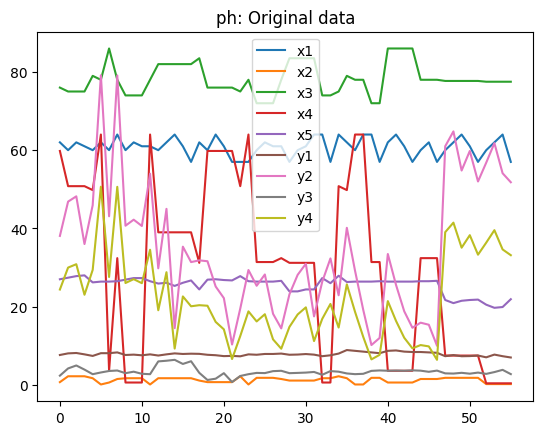

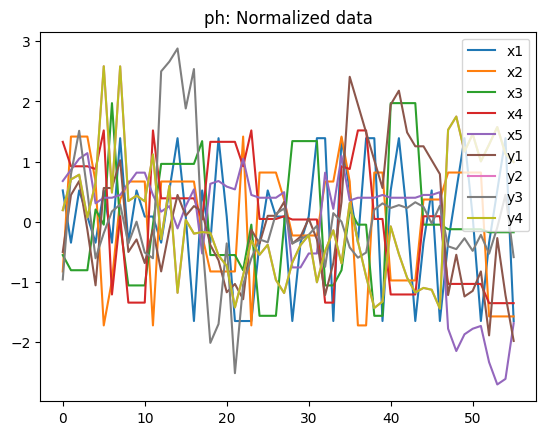

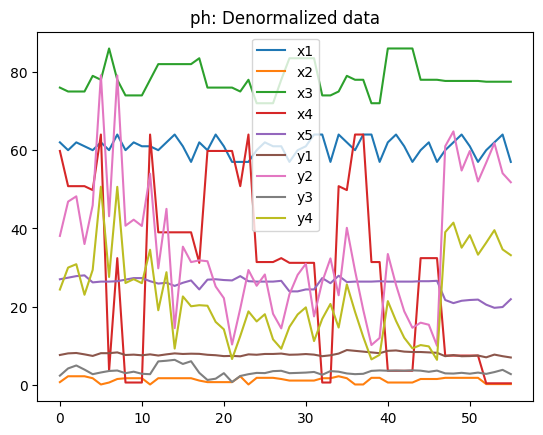

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def getData():
    df_orig = pd.read_excel("../../../data.xlsx")    
    df = pd.DataFrame(scaler.fit_transform(df_orig), columns=df_orig.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)
    return (df_orig, df, df_denorm)

def create_dataframe(df, output):
    x1, x2, x3, x4, x5  = df['x1'], df['x2'], df['x3'], df['x4'], df['x5']

    input = np.vstack([x1, x2, x3, x4, x5 ]).T
    output = np.array(df[output])
    scaler.fit(output.reshape(-1, 1))
    return output, input

def test_out_scaler():
    out = df_orig["y1"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

def show_norm(label):
    df_orig.plot(title=f"{label}: Original data")
    df.plot(title=f"{label}: Normalized data")
    df_denorm.plot(title=f"{label}: Denormalized data")

df_orig, df, df_denorm = getData()
output, input = create_dataframe(df, output="y1")
test_out_scaler()
show_norm(label="ph")


In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer
        
        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-04-05 00:50:10.982099: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 00:50:11.051833: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 00:50:11.051873: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 00:50:11.053375: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-05 00:50:11.068571: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 00:50:11.073563: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [5]:
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
    
    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
    
    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
    # Calculando a saida com os dados normalizados
      pred = self.lm_model.predict(self.input).flatten()
      test_pred = self.lm_model.predict(self.test_input).flatten()
      val_pred = self.lm_model.predict(self.val_input).flatten()
      vt_pred = self.lm_model.predict(self.vt_input).flatten()
  
    # Calculando as metricas com a saida desnormalizada
      self.pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
      test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
      val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
      vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))

      self.out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
      test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
      val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
      vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))      

      r2 = r2_score(self.out_denorm, self.pred_denorm)
      r2_test = r2_score(test_denorm, test_pred_denorm)
      r2_val = r2_score(val_denorm, val_pred_denorm)
      r2_vt = r2_score(vt_denorm,  vt_pred_denorm)

      mse = mean_squared_error(self.out_denorm, self.pred_denorm)
      mse_test = mean_squared_error(test_denorm, test_pred_denorm)
      mse_val = mean_squared_error(val_denorm, val_pred_denorm)
      mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)

      metrics = {
                      'r2': r2,
                      'r2_test': r2_test,
                      'r2_val': r2_val,
                      'r2_vt': r2_vt,
                      'mse': mse,
                      'mse_test': mse_test,
                      'mse_val': mse_val,
                      'mse_vt': mse_vt
                      }

      return metrics

In [6]:
from itertools import product
import pickle

class Tester:
  def __init__(self, input, output, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = input, output
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=5,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path) 

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)

  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be <= to descending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    
    return(save)

# Init
  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinação {count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults(sort_by, header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

In [7]:
tester = Tester(input, output, run_times=25, dataset_run_times=10)

In [8]:
tester.Loop(sort_by='r2',
            boundarie=0.8,
            hidden_sizes = [[5], [10], [15], [20], [25], [30], [35], [40], [45]],
            regularizers=[0.01, 0.1],
            learning_rate=[0.1])

Testando combinação 1: Hidden Size=[5], regularizer=0.01, learning_rate=0.1
+++++++++++ [1_0] | 1 ++++++++++++++++++
Elapsed time:  1.904066864000015
Stopped at epoch:  8
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Elapsed time:  0.5070366529998864
Stopped at epoch:  6
1/1 [==============================] - 0s 59ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Elapsed time:  0.6511127879994092
Stopped at epoch:  8
1/1 [==============================] - 0s 53ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Elapsed time:  0.552871996000249
Stopped at epoch:  7
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Elapsed time:  0.6022498009997435
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Elapsed time:  0.7507083370001055
Stopped at epoch:  13
1/1 [==============================] - 0s 24ms/step
+++++++++++ [1_0] | 7 +++++++++++++++

2024-04-05 00:50:21.872057: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.558337701999335
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Elapsed time:  0.4291668089999803
Stopped at epoch:  6
1/1 [==============================] - 0s 68ms/step
+++++++++++ [1_0] | 9 ++++++++++++++++++
Elapsed time:  0.5508633300005386
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_0] | 10 ++++++++++++++++++
Elapsed time:  0.32676763600011327
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_0] | 11 ++++++++++++++++++
Elapsed time:  0.41453916400041635
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [1_0] | 12 ++++++++++++++++++
Elapsed time:  0.39512377200026094
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [1_0] | 13 ++++++++++++++++++
Elapsed time:  0.4099331279994658
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step

2024-04-05 00:52:09.009879: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_5] | 24 ++++++++++++++++++
Elapsed time:  0.38423843100008526
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_5] | 25 ++++++++++++++++++
Elapsed time:  0.36680191600044054
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_6] | 1 ++++++++++++++++++
Elapsed time:  0.5395990770002754
Stopped at epoch:  14
1/1 [==============================] - 0s 19ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Elapsed time:  0.39714885400007915
Stopped at epoch:  7
1/1 [==============================] - 0s 24ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Elapsed time:  0.45423896400006925
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Elapsed time:  0.39543911700002354
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Elapsed tim

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_4_13,0.802695,0.087644,0.547303,0.339155,0.036911,0.139002,0.092564,0.117149
model_3_4_0,0.804105,0.623806,0.797084,0.718689,0.036648,0.057315,0.041491,0.049869
model_3_4_12,0.807173,0.117072,0.562211,0.360637,0.036074,0.134519,0.089516,0.113341
model_3_4_11,0.811749,0.148927,0.578304,0.383866,0.035217,0.129666,0.086226,0.109223
model_3_4_10,0.816335,0.183240,0.595599,0.408866,0.034360,0.124438,0.082689,0.104792
model_3_4_1,0.818792,0.583212,0.783878,0.693051,0.033900,0.063500,0.044191,0.054413
model_3_4_9,0.820806,0.219981,0.614104,0.435628,0.033523,0.118840,0.078906,0.100047
model_3_4_8,0.825005,0.259078,0.633813,0.464115,0.032738,0.112884,0.074875,0.094997
model_3_4_2,0.827675,0.535725,0.766210,0.661854,0.032238,0.070735,0.047804,0.059944
model_3_4_7,0.828724,0.300414,0.654692,0.494256,0.032042,0.106586,0.070606,0.089654


DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Elapsed time:  0.2710891740007355
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Elapsed time:  0.2788320620002196
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Elapsed time:  0.35170129900052416
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Elapsed time:  0.2646360700000514
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Elapsed time:  0.27224600999943505
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Elapsed time:  0.3048883229994317
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Elapsed time:  0.2591456809

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_5_0,0.816317,0.413574,0.989764,0.860780,0.034363,0.025040,0.001283,0.013860
model_3_5_1,0.845856,0.412497,0.973262,0.850760,0.028837,0.025086,0.003351,0.014857
model_3_5_24,0.854176,-0.845114,0.194535,0.103903,0.027280,0.078784,0.100940,0.089210
model_3_5_23,0.855818,-0.835136,0.210456,0.115600,0.026973,0.078358,0.098945,0.088046
model_3_5_22,0.857613,-0.823867,0.228102,0.128612,0.026637,0.077877,0.096733,0.086750
model_3_5_21,0.859573,-0.811122,0.247643,0.143081,0.026271,0.077333,0.094284,0.085310
model_3_5_20,0.861705,-0.796675,0.269252,0.159162,0.025872,0.076716,0.091576,0.083709
model_3_5_19,0.864015,-0.780259,0.293106,0.177021,0.025440,0.076015,0.088587,0.081931
model_3_5_2,0.865888,0.339521,0.950817,0.820894,0.025089,0.028202,0.006163,0.017831
model_3_5_18,0.866507,-0.761566,0.319386,0.196832,0.024973,0.075217,0.085294,0.079959


DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Elapsed time:  0.31810077099999035
Stopped at epoch:  8
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Elapsed time:  0.20707955099987885
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Elapsed time:  0.25910082700011117
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Elapsed time:  0.2756080640001528
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Elapsed time:  0.3370635040000707
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Elapsed time:  0.31686429900037183
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Elapsed time:  0.43345691

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_6_24,0.908431,0.343872,0.676254,0.611206,0.017130,0.044077,0.069775,0.056170
model_3_6_23,0.909735,0.352302,0.681823,0.617190,0.016886,0.043511,0.068575,0.055306
model_3_6_22,0.911158,0.361639,0.687934,0.623779,0.016620,0.042884,0.067258,0.054354
model_3_6_21,0.912707,0.371977,0.694628,0.631023,0.016331,0.042189,0.065815,0.053307
model_3_6_20,0.914387,0.383422,0.701948,0.638979,0.016016,0.041420,0.064238,0.052158
model_3_6_0,0.915831,0.929607,0.910886,0.920111,0.015746,0.004729,0.019206,0.011542
model_3_6_19,0.916203,0.396084,0.709935,0.647703,0.015677,0.040570,0.062516,0.050898
model_3_6_18,0.918159,0.410085,0.718624,0.657250,0.015311,0.039629,0.060643,0.049518
model_3_6_17,0.920256,0.425558,0.728051,0.667676,0.014918,0.038590,0.058612,0.048012
model_3_6_16,0.922489,0.442645,0.738239,0.679035,0.014500,0.037442,0.056416,0.046371


DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Elapsed time:  0.3473899930004336
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Elapsed time:  0.2944536490003884
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Elapsed time:  0.2947529040002337
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Elapsed time:  0.23086801799945533
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Elapsed time:  0.2395587950004483
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Elapsed time:  0.3027449789997263
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Elapsed time:  0.25471602800

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_7_24,0.875977,0.506872,0.740721,0.595163,0.023202,0.113322,0.034759,0.076351
model_3_7_23,0.877158,0.511447,0.743729,0.599120,0.022981,0.112271,0.034356,0.075605
model_3_7_22,0.878447,0.516470,0.747000,0.603454,0.022740,0.111116,0.033917,0.074787
model_3_7_21,0.879851,0.521975,0.750545,0.608191,0.022477,0.109851,0.033442,0.073894
model_3_7_20,0.881376,0.527998,0.754376,0.613358,0.022192,0.108467,0.032929,0.072920
model_3_7_19,0.883027,0.534574,0.758503,0.618981,0.021883,0.106956,0.032375,0.071859
model_3_7_18,0.884808,0.541736,0.762932,0.625082,0.021550,0.105310,0.031782,0.070708
model_3_7_17,0.886721,0.549514,0.767665,0.631683,0.021192,0.103523,0.031147,0.069464
model_3_7_16,0.888768,0.557935,0.772698,0.638799,0.020809,0.101588,0.030472,0.068122
model_3_7_15,0.890943,0.567018,0.778022,0.646439,0.020402,0.099500,0.029759,0.066681


DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Elapsed time:  0.27219508000052883
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Elapsed time:  0.26603073100068286
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Elapsed time:  0.3192860250001104
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Elapsed time:  0.30963384400001814
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Elapsed time:  0.2753364709997186
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Elapsed time:  0.3173152979998122
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Elapsed time:  0.273893202

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_8_24,0.883694,0.892346,0.173972,0.731338,0.021758,0.038997,0.107795,0.071373
model_3_8_23,0.884453,0.893719,0.178452,0.733365,0.021616,0.038500,0.107211,0.070834
model_3_8_22,0.885280,0.895234,0.183434,0.735611,0.021462,0.037951,0.106561,0.070238
model_3_8_21,0.886178,0.896906,0.188978,0.738099,0.021294,0.037345,0.105837,0.069577
model_3_8_20,0.887150,0.898748,0.195146,0.740855,0.021112,0.036678,0.105032,0.068845
model_3_8_19,0.888199,0.900777,0.202013,0.743906,0.020915,0.035943,0.104136,0.068034
model_3_8_18,0.889326,0.903006,0.209660,0.747283,0.020705,0.035136,0.103138,0.067137
model_3_8_0,0.889785,0.969107,0.793451,0.929952,0.020619,0.011191,0.026954,0.018609
model_3_8_17,0.890530,0.905452,0.218181,0.751019,0.020479,0.034249,0.102026,0.066144
model_3_8_16,0.891809,0.908132,0.227681,0.755149,0.020240,0.033279,0.100786,0.065047


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Elapsed time:  0.2952093750000131
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Elapsed time:  0.22758950800016464
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Elapsed time:  0.28637616099968
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Elapsed time:  0.29069840000011027
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Elapsed time:  0.27203898299922
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Elapsed time:  0.3246955029999299
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Elapsed time:  0.37055253000016

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_9_0,0.899024,0.974654,0.805114,0.921900,0.018890,0.008023,0.032923,0.019741
model_3_9_1,0.910983,0.974173,0.797103,0.919061,0.016653,0.008176,0.034277,0.020458
model_3_9_23,0.911262,0.789406,0.756066,0.783651,0.016601,0.066664,0.041209,0.054685
model_3_9_24,0.911262,0.789406,0.756066,0.783651,0.016601,0.066664,0.041209,0.054685
model_3_9_22,0.911263,0.789410,0.756066,0.783654,0.016601,0.066662,0.041209,0.054684
model_3_9_21,0.911264,0.789412,0.756066,0.783655,0.016601,0.066662,0.041209,0.054684
model_3_9_20,0.911264,0.789413,0.756066,0.783655,0.016601,0.066662,0.041209,0.054684
model_3_9_19,0.911266,0.789421,0.756065,0.783661,0.016600,0.066659,0.041209,0.054683
model_3_9_18,0.911267,0.789423,0.756066,0.783662,0.016600,0.066658,0.041209,0.054682
model_3_9_17,0.911268,0.789427,0.756066,0.783665,0.016600,0.066657,0.041209,0.054682


DataFrame salvo em ../results/metrics_3_9
Testando combinação 4: Hidden Size=[10], regularizer=0.1, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Elapsed time:  0.5117216810003811
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Elapsed time:  0.3062744250000833
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Elapsed time:  0.35221280500081775
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Elapsed time:  0.28247378200012463
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Elapsed time:  0.1671446600003037
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Elapsed time:  0.2603856050000104
Stopped at epoch:  6
1/1 [==============================] - 0s 24

2024-04-05 00:58:43.157237: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3336112769993633
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_3] | 6 ++++++++++++++++++
Elapsed time:  0.2858684489992811
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_3] | 7 ++++++++++++++++++
Elapsed time:  0.3531355129998701
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_3] | 8 ++++++++++++++++++
Elapsed time:  0.254940945999806
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_3] | 9 ++++++++++++++++++
Elapsed time:  0.2862789420005356
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_3] | 10 ++++++++++++++++++
Elapsed time:  0.1850962119997348
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_3] | 11 ++++++++++++++++++
Elapsed time:  0.3066473870003392
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
++++

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_5_3,0.805466,0.620408,-0.208282,0.379122,0.036393,0.077066,0.129430,0.101708
model_4_5_2,0.811375,0.619384,-0.049202,0.427403,0.035287,0.077274,0.112389,0.093799
model_4_5_1,0.815303,0.620063,0.101875,0.474338,0.034553,0.077136,0.096206,0.086110
model_4_5_0,0.816153,0.623678,0.233254,0.517139,0.034394,0.076402,0.082133,0.079099


DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Elapsed time:  0.2516232289999607
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Elapsed time:  0.28688542600048095
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Elapsed time:  0.1900938930002667
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Elapsed time:  0.2342856249997567
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Elapsed time:  0.28398565400038933
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Elapsed time:  0.2673293959996954
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Elapsed time:  0.3264902880

2024-04-05 00:59:32.203941: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.36536845699993137
Stopped at epoch:  6
1/1 [==============================] - 0s 48ms/step
+++++++++++ [4_6] | 15 ++++++++++++++++++
Elapsed time:  0.2769586790000176
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_6] | 16 ++++++++++++++++++
Elapsed time:  0.2966625950002708
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_6] | 17 ++++++++++++++++++
Elapsed time:  0.3287393079999674
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_6] | 18 ++++++++++++++++++
Elapsed time:  0.19962824799949885
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_6] | 19 ++++++++++++++++++
Elapsed time:  0.3110874359999798
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_6] | 20 ++++++++++++++++++
Elapsed time:  0.22805211500053701
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/s

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_6_21,0.806191,0.367412,-0.151934,0.222847,0.036257,0.131027,0.104565,0.118574
model_4_6_20,0.807851,0.375917,-0.145085,0.230876,0.035947,0.129265,0.103943,0.117349
model_4_6_19,0.809639,0.385137,-0.137139,0.239728,0.035612,0.127356,0.103222,0.115999
model_4_6_0,0.811112,0.746332,0.607829,0.707891,0.035337,0.052542,0.035599,0.044569
model_4_6_18,0.811556,0.395116,-0.127902,0.249486,0.035254,0.125289,0.102384,0.114510
model_4_6_17,0.813603,0.405888,-0.117157,0.260237,0.034871,0.123057,0.101408,0.112869
model_4_6_16,0.815776,0.417495,-0.104653,0.272079,0.034464,0.120653,0.100273,0.111063
model_4_6_15,0.818067,0.429969,-0.090104,0.285117,0.034035,0.118070,0.098953,0.109073
model_4_6_14,0.820465,0.443348,-0.073191,0.299468,0.033587,0.115298,0.097417,0.106884
model_4_6_13,0.822950,0.457665,-0.053554,0.315255,0.033122,0.112333,0.095635,0.104475


DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Elapsed time:  0.36267022300035023
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Elapsed time:  0.2916385710004761
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Elapsed time:  0.20519815599982394
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Elapsed time:  0.28956557899982727
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Elapsed time:  0.3802149109997117
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Elapsed time:  0.2197046909996061
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Elapsed time:  0.306058997

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_9_15,0.802707,0.501865,-0.198664,0.368739,0.036909,0.117480,0.118840,0.118120
model_4_9_14,0.806029,0.510205,-0.159613,0.384041,0.036288,0.115513,0.114968,0.115257
model_4_9_13,0.809581,0.519699,-0.116454,0.401137,0.035623,0.113274,0.110689,0.112058
model_4_9_12,0.813370,0.530588,-0.068769,0.420294,0.034914,0.110706,0.105962,0.108473
model_4_9_11,0.817401,0.543197,-0.016111,0.441836,0.034160,0.107732,0.100741,0.104442
model_4_9_0,0.819313,0.796734,0.949005,0.851653,0.033803,0.047938,0.005056,0.027758
model_4_9_10,0.821684,0.557955,0.042001,0.466174,0.033359,0.104252,0.094980,0.099888
model_4_9_9,0.826230,0.575447,0.106073,0.493821,0.032508,0.100126,0.088627,0.094715
model_4_9_8,0.831058,0.596447,0.176621,0.525424,0.031605,0.095174,0.081633,0.088802
model_4_9_7,0.836183,0.621923,0.254158,0.561756,0.030647,0.089165,0.073946,0.082003


DataFrame salvo em ../results/metrics_4_9
Testando combinação 5: Hidden Size=[15], regularizer=0.01, learning_rate=0.1
+++++++++++ [5_0] | 1 ++++++++++++++++++
Elapsed time:  0.5078937190000943
Stopped at epoch:  7
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Elapsed time:  0.36361770999974397
Stopped at epoch:  8
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Elapsed time:  0.22700611000072968
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Elapsed time:  0.333291499000552
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Elapsed time:  0.2257004050006799
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Elapsed time:  0.20816553700024087
Stopped at epoch:  6
1/1 [==============================] - 0s 2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_4_12,0.800645,0.500084,-0.241345,0.233972,0.037295,0.085083,0.149543,0.115417
model_5_4_0,0.805281,0.807670,0.852675,0.829550,0.036428,0.032734,0.017748,0.025682
model_5_4_11,0.807346,0.519463,-0.168589,0.272936,0.036041,0.081785,0.140778,0.109547
model_5_4_10,0.814037,0.540170,-0.090848,0.314570,0.034789,0.078261,0.131413,0.103274
model_5_4_9,0.820557,0.562189,-0.008162,0.358849,0.033570,0.074513,0.121452,0.096602
model_5_4_1,0.822465,0.776660,0.766962,0.778756,0.033213,0.038011,0.028074,0.033335
model_5_4_8,0.826693,0.585479,0.079324,0.405695,0.032422,0.070549,0.110913,0.089544
model_5_4_7,0.832167,0.609968,0.171322,0.454955,0.031398,0.066382,0.099830,0.082122
model_5_4_2,0.833056,0.746759,0.671252,0.724862,0.031232,0.043100,0.039604,0.041455
model_5_4_6,0.836625,0.635561,0.267353,0.506393,0.030564,0.062026,0.088261,0.074372


DataFrame salvo em ../results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Elapsed time:  0.41689715000029537
Stopped at epoch:  9
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Elapsed time:  0.2808387610002683
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Elapsed time:  0.2914398879993314
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Elapsed time:  0.2971107339999435
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Elapsed time:  0.3352618799999618
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_5] | 6 ++++++++++++++++++
Elapsed time:  0.2575238770004944
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_5] | 7 ++++++++++++++++++
Elapsed time:  0.25825232300

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_5_0,0.870675,0.805735,0.970260,0.881159,0.024194,0.038378,0.005543,0.022927
model_5_5_1,0.886224,0.793545,0.970896,0.874840,0.021285,0.040786,0.005425,0.024146
model_5_5_2,0.898301,0.781005,0.971024,0.868099,0.019026,0.043264,0.005401,0.025446
model_5_5_3,0.907632,0.768501,0.970785,0.861212,0.017280,0.045734,0.005446,0.026775
model_5_5_4,0.914792,0.756306,0.970285,0.854373,0.015941,0.048143,0.005539,0.028094
model_5_5_5,0.920240,0.744604,0.969602,0.847718,0.014921,0.050455,0.005666,0.029378
model_5_5_6,0.924340,0.733506,0.968793,0.841334,0.014154,0.052647,0.005817,0.030610
model_5_5_7,0.927384,0.723080,0.967904,0.835277,0.013585,0.054707,0.005983,0.031778
model_5_5_8,0.929601,0.713354,0.966970,0.829580,0.013170,0.056628,0.006157,0.032877
model_5_5_24,0.930842,0.633019,0.955805,0.780950,0.012938,0.072499,0.008238,0.042259


DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Elapsed time:  0.2672825930003455
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Elapsed time:  0.34331525600009627
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Elapsed time:  0.3104063699993276
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Elapsed time:  0.2582318659997327
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Elapsed time:  0.3326396009997552
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Elapsed time:  0.2532209929995588
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Elapsed time:  0.32563320999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_6_24,0.913028,0.920070,-0.256151,0.700662,0.016270,0.021131,0.089954,0.053518
model_5_6_23,0.913639,0.921122,-0.248801,0.702871,0.016156,0.020853,0.089428,0.053124
model_5_6_22,0.914312,0.922284,-0.240646,0.705317,0.016030,0.020546,0.088844,0.052686
model_5_6_21,0.915053,0.923567,-0.231595,0.708028,0.015892,0.020207,0.088196,0.052202
model_5_6_20,0.915868,0.924982,-0.221552,0.711028,0.015739,0.019833,0.087476,0.051665
model_5_6_19,0.916762,0.926541,-0.210415,0.714348,0.015572,0.019421,0.086679,0.051072
model_5_6_18,0.917741,0.928255,-0.198071,0.718017,0.015389,0.018967,0.085795,0.050416
model_5_6_17,0.918812,0.930138,-0.184394,0.722069,0.015189,0.018470,0.084816,0.049691
model_5_6_16,0.919978,0.932201,-0.169254,0.726538,0.014970,0.017924,0.083731,0.048892
model_5_6_15,0.921246,0.934456,-0.152508,0.731459,0.014733,0.017328,0.082532,0.048012


DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Elapsed time:  0.3282944380007393
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Elapsed time:  0.4311197440001706
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Elapsed time:  0.19534862999989855
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Elapsed time:  0.35181204800028354
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Elapsed time:  0.23649913999997807
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Elapsed time:  0.28725615100029245
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Elapsed time:  0.29503634

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_7_14,0.803059,-0.117241,0.348795,0.307840,0.036843,0.078160,0.166171,0.119577
model_5_7_13,0.809958,-0.050014,0.366947,0.334869,0.035553,0.073457,0.161539,0.114907
model_5_7_12,0.817488,0.018715,0.388692,0.364718,0.034144,0.068649,0.155991,0.109751
model_5_7_11,0.825692,0.087564,0.414856,0.397665,0.032609,0.063832,0.149314,0.104059
model_5_7_10,0.834628,0.155119,0.446410,0.434080,0.030937,0.059106,0.141262,0.097768
model_5_7_9,0.844379,0.220315,0.484383,0.474451,0.029113,0.054545,0.131573,0.090793
model_5_7_8,0.855016,0.282831,0.529599,0.519282,0.027123,0.050172,0.120035,0.083048
model_5_7_7,0.866530,0.343342,0.582268,0.568865,0.024969,0.045938,0.106595,0.074483
model_5_7_6,0.878725,0.403407,0.641493,0.622908,0.022688,0.041736,0.091482,0.065146
model_5_7_5,0.891125,0.464915,0.705007,0.680242,0.020368,0.037434,0.075275,0.055241


DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Elapsed time:  0.27169897200019477
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Elapsed time:  0.3348903080004675
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Elapsed time:  0.2660273530000268
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Elapsed time:  0.2063247850001062
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Elapsed time:  0.2384373559998494
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Elapsed time:  0.3122225140004957
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Elapsed time:  0.27807160699

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_8_0,0.805033,0.960037,0.951415,0.955347,0.036474,0.006366,0.012400,0.009205
model_5_8_1,0.837921,0.960731,0.942688,0.950547,0.030321,0.006255,0.014627,0.010195
model_5_8_2,0.862772,0.957003,0.929988,0.941622,0.025672,0.006849,0.017868,0.012035
model_5_8_3,0.881324,0.949870,0.914820,0.929868,0.022202,0.007985,0.021740,0.014458
model_5_8_4,0.894938,0.940065,0.898299,0.916232,0.019655,0.009547,0.025956,0.017269
model_5_8_24,0.895863,0.680879,0.695515,0.692066,0.019482,0.050833,0.077710,0.063481
model_5_8_23,0.897343,0.688339,0.699233,0.697284,0.019205,0.049645,0.076761,0.062406
model_5_8_22,0.898933,0.696472,0.703356,0.703013,0.018907,0.048349,0.075709,0.061225
model_5_8_21,0.900631,0.705317,0.707927,0.709294,0.018590,0.046940,0.074543,0.059930
model_5_8_20,0.902433,0.714911,0.712991,0.716169,0.018253,0.045412,0.073250,0.058512


DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Elapsed time:  0.18455609700049536
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Elapsed time:  0.2832693370000925
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Elapsed time:  0.2551692719998755
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Elapsed time:  0.30440859899954376
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Elapsed time:  0.23200976099997206
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Elapsed time:  0.27852130199971725
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Elapsed time:  0.29577946

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_9_0,0.914540,0.980521,0.997525,0.984508,0.015988,0.004134,0.000157,0.002263
model_5_9_1,0.929444,0.978952,0.991229,0.982012,0.013199,0.004467,0.000557,0.002627
model_5_9_2,0.941314,0.977513,0.982305,0.979078,0.010979,0.004772,0.001125,0.003056
model_5_9_3,0.950747,0.976207,0.971680,0.975897,0.009214,0.005050,0.001800,0.003520
model_5_9_4,0.958225,0.975025,0.960057,0.972608,0.007815,0.005300,0.002538,0.004001
model_5_9_5,0.964137,0.973959,0.947956,0.969310,0.006709,0.005527,0.003307,0.004482
model_5_9_6,0.968794,0.972996,0.935758,0.966072,0.005838,0.005731,0.004083,0.004955
model_5_9_7,0.972448,0.972126,0.923737,0.962941,0.005154,0.005915,0.004847,0.005412
model_5_9_8,0.975302,0.971338,0.912084,0.959949,0.004621,0.006083,0.005587,0.005849
model_5_9_9,0.977516,0.970623,0.900929,0.957114,0.004206,0.006235,0.006296,0.006263


DataFrame salvo em ../results/metrics_5_9
Testando combinação 6: Hidden Size=[15], regularizer=0.1, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Elapsed time:  0.5423780800001623
Stopped at epoch:  7
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Elapsed time:  0.480661605000023
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Elapsed time:  0.3025621209999372
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Elapsed time:  0.310193834000529
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Elapsed time:  0.3088436680000086
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Elapsed time:  0.269952877999458
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/st

2024-04-05 01:03:01.272111: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.39117076599995926
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_0] | 24 ++++++++++++++++++
Elapsed time:  0.26295857100012654
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_0] | 25 ++++++++++++++++++
Elapsed time:  0.3033805699997174
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_1] | 1 ++++++++++++++++++
Elapsed time:  0.25609595000059926
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_1] | 2 ++++++++++++++++++
Elapsed time:  0.2581868810002561
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_1] | 3 ++++++++++++++++++
Elapsed time:  0.3025466059998507
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_1] | 4 ++++++++++++++++++
Elapsed time:  0.2738700070003688
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_4_0,0.807910,0.679785,0.664302,0.677577,0.035936,0.025694,0.065628,0.044487
model_6_4_1,0.820724,0.695422,0.592457,0.634486,0.033539,0.024439,0.079674,0.050432
model_6_4_2,0.830318,0.710998,0.527593,0.596032,0.031744,0.023189,0.092355,0.055738
model_6_4_3,0.837664,0.722362,0.472515,0.562806,0.030369,0.022278,0.103123,0.060322
model_6_4_20,0.840808,0.318446,0.260718,0.297227,0.029781,0.054688,0.144529,0.096966
model_6_4_19,0.842231,0.338016,0.264103,0.305509,0.029515,0.053117,0.143867,0.095823
model_6_4_4,0.843343,0.726470,0.428063,0.534431,0.029307,0.021948,0.111813,0.064237
model_6_4_18,0.843728,0.359526,0.267767,0.314575,0.029235,0.051391,0.143150,0.094572
model_6_4_17,0.845285,0.383078,0.271723,0.324464,0.028944,0.049501,0.142377,0.093208
model_6_4_16,0.846882,0.408731,0.275999,0.335213,0.028645,0.047443,0.141541,0.091724


DataFrame salvo em ../results/metrics_6_4
+++++++++++ [6_5] | 1 ++++++++++++++++++
Elapsed time:  0.341292457000236
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_5] | 2 ++++++++++++++++++
Elapsed time:  0.38880006199997297
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Elapsed time:  0.30250677399999404
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Elapsed time:  0.3055610310002521
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Elapsed time:  0.32168631800050207
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_5] | 6 ++++++++++++++++++
Elapsed time:  0.28660334999949555
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_5] | 7 ++++++++++++++++++
Elapsed time:  0.247666262

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_5_0,0.856328,0.887102,0.670712,0.826600,0.026878,0.038148,0.051381,0.044375
model_6_5_1,0.868264,0.890378,0.649442,0.822787,0.024645,0.037041,0.054700,0.045351
model_6_5_2,0.877359,0.892477,0.628570,0.818265,0.022943,0.036332,0.057956,0.046508
model_6_5_3,0.884205,0.893665,0.608371,0.813300,0.021663,0.035930,0.061108,0.047779
model_6_5_4,0.889273,0.894153,0.589037,0.808093,0.020715,0.035766,0.064125,0.049111
model_6_5_24,0.891610,0.875898,0.396552,0.740103,0.020277,0.041934,0.094160,0.066511
model_6_5_23,0.892102,0.876527,0.400061,0.741550,0.020185,0.041721,0.093612,0.066141
model_6_5_22,0.892629,0.877211,0.403939,0.743141,0.020087,0.041490,0.093007,0.065733
model_6_5_5,0.892942,0.894108,0.570695,0.802799,0.020028,0.035781,0.066987,0.050466
model_6_5_21,0.893190,0.877952,0.408225,0.744889,0.019982,0.041240,0.092338,0.065286


DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Elapsed time:  0.2551721500003623
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Elapsed time:  0.3279952980001326
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Elapsed time:  0.4115308250002272
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Elapsed time:  0.27221187200029817
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Elapsed time:  0.3248781299998882
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Elapsed time:  0.3177297850006653
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Elapsed time:  0.27331276699

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_6_0,0.921437,0.897853,0.953754,0.917776,0.014697,0.019792,0.004378,0.012538
model_6_6_1,0.931177,0.896400,0.938107,0.912227,0.012875,0.020073,0.005860,0.013384
model_6_6_2,0.938483,0.894041,0.920557,0.905512,0.011508,0.020530,0.007521,0.014408
model_6_6_3,0.943894,0.891081,0.901979,0.898093,0.010496,0.021104,0.009280,0.015540
model_6_6_24,0.947788,0.836557,0.659274,0.790504,0.009768,0.031668,0.032258,0.031946
model_6_6_4,0.947829,0.887736,0.883012,0.890301,0.009760,0.021752,0.011076,0.016728
model_6_6_23,0.948211,0.837711,0.663678,0.792567,0.009689,0.031444,0.031841,0.031631
model_6_6_22,0.948665,0.838979,0.668536,0.794839,0.009604,0.031199,0.031381,0.031285
model_6_6_21,0.949150,0.840369,0.673892,0.797339,0.009513,0.030929,0.030874,0.030903
model_6_6_20,0.949665,0.841892,0.679792,0.800087,0.009416,0.030634,0.030316,0.030484


DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Elapsed time:  0.3028029229999447
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Elapsed time:  0.3089487960005499
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Elapsed time:  0.294079841999519
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Elapsed time:  0.3185886350001965
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Elapsed time:  0.3052565570005754
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Elapsed time:  0.2625518369995916
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Elapsed time:  0.3146639289998

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_7_24,0.907550,0.272179,0.311629,0.333089,0.017295,0.075458,0.035984,0.056882
model_6_7_23,0.908549,0.281763,0.316150,0.340560,0.017108,0.074464,0.035747,0.056244
model_6_7_22,0.909647,0.292321,0.321158,0.348799,0.016903,0.073370,0.035485,0.055542
model_6_7_21,0.910850,0.303937,0.326703,0.357874,0.016678,0.072165,0.035196,0.054768
model_6_7_20,0.912166,0.316702,0.332842,0.367858,0.016432,0.070842,0.034875,0.053916
model_6_7_19,0.913604,0.330708,0.339623,0.378828,0.016163,0.069390,0.034520,0.052981
model_6_7_18,0.915171,0.346055,0.347120,0.390867,0.015870,0.067799,0.034128,0.051954
model_6_7_17,0.916873,0.362837,0.355395,0.404052,0.015551,0.066059,0.033696,0.050829
model_6_7_16,0.918717,0.381150,0.364515,0.418468,0.015206,0.064160,0.033219,0.049600
model_6_7_15,0.920707,0.401089,0.374555,0.434195,0.014834,0.062093,0.032694,0.048258


DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Elapsed time:  0.22039802800009056
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Elapsed time:  0.30553063600018504
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Elapsed time:  0.2931164829997215
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Elapsed time:  0.2445927059998212
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Elapsed time:  0.31107839200012677
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Elapsed time:  0.25987356299992825
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Elapsed time:  0.40565761

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_8_0,0.924113,0.942610,0.994820,0.976787,0.014197,0.006324,0.001202,0.003914
model_6_8_1,0.936710,0.941288,0.992137,0.974591,0.011840,0.006470,0.001825,0.004284
model_6_8_2,0.946178,0.935933,0.988113,0.970132,0.010069,0.007060,0.002758,0.005036
model_6_8_3,0.953179,0.927771,0.983124,0.964077,0.008759,0.007960,0.003916,0.006057
model_6_8_24,0.955091,0.741190,0.887344,0.837482,0.008401,0.028521,0.026140,0.027401
model_6_8_23,0.955749,0.745323,0.889437,0.840268,0.008278,0.028065,0.025655,0.026931
model_6_8_22,0.956456,0.749859,0.891733,0.843325,0.008146,0.027566,0.025122,0.026416
model_6_8_21,0.957213,0.754830,0.894248,0.846674,0.008004,0.027018,0.024538,0.025851
model_6_8_20,0.958019,0.760267,0.896998,0.850336,0.007854,0.026419,0.023900,0.025233
model_6_8_4,0.958239,0.917703,0.977473,0.956933,0.007813,0.009069,0.005227,0.007261


DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Elapsed time:  0.2884308630000305
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Elapsed time:  0.33357290499952796
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Elapsed time:  0.3425705649997326
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Elapsed time:  0.30100975799996377
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Elapsed time:  0.21032572100011748
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Elapsed time:  0.3120669199997792
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Elapsed time:  0.399999338

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_9_0,0.963337,0.997165,0.977208,0.989761,0.006859,0.000590,0.003615,0.002014
model_6_9_1,0.969652,0.995139,0.980141,0.989738,0.005677,0.001012,0.003150,0.002018
model_6_9_2,0.974438,0.992308,0.981510,0.988671,0.004782,0.001602,0.002933,0.002228
model_6_9_3,0.978017,0.988916,0.981747,0.986860,0.004113,0.002308,0.002895,0.002584
model_6_9_4,0.980646,0.985152,0.981187,0.984537,0.003621,0.003092,0.002984,0.003041
model_6_9_24,0.981281,0.926719,0.955460,0.942018,0.003502,0.015260,0.007065,0.011404
model_6_9_23,0.981551,0.928079,0.956093,0.943021,0.003451,0.014977,0.006965,0.011206
model_6_9_22,0.981840,0.929571,0.956788,0.944121,0.003397,0.014666,0.006854,0.010990
model_6_9_21,0.982148,0.931205,0.957550,0.945326,0.003340,0.014326,0.006733,0.010753
model_6_9_20,0.982474,0.932991,0.958386,0.946644,0.003279,0.013954,0.006601,0.010494


DataFrame salvo em ../results/metrics_6_9
Testando combinação 7: Hidden Size=[20], regularizer=0.01, learning_rate=0.1
+++++++++++ [7_0] | 1 ++++++++++++++++++
Elapsed time:  0.5914740409998558
Stopped at epoch:  9
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Elapsed time:  0.31065185900024517
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Elapsed time:  0.26959537400034606
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Elapsed time:  0.27256683300038276
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Elapsed time:  0.18233168499955354
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Elapsed time:  0.23492849800004478
Stopped at epoch:  6
1/1 [==============================] - 0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_3_0,0.801162,0.705359,0.876305,0.861107,0.037198,0.016992,0.038432,0.027081
model_7_3_1,0.822120,0.658332,0.847764,0.832341,0.033277,0.019704,0.047300,0.032690
model_7_3_2,0.838051,0.616270,0.821752,0.806249,0.030297,0.022129,0.055382,0.037777
model_7_3_3,0.849966,0.578329,0.798044,0.782529,0.028068,0.024317,0.062748,0.042402
model_7_3_4,0.858721,0.543884,0.776380,0.760890,0.026430,0.026304,0.069479,0.046621
model_7_3_20,0.863801,0.277471,0.586474,0.576767,0.025480,0.041668,0.128483,0.082522
model_7_3_5,0.865009,0.512518,0.756529,0.741093,0.025254,0.028113,0.075646,0.050482
model_7_3_19,0.865160,0.284562,0.592971,0.582749,0.025226,0.041259,0.126464,0.081355
model_7_3_18,0.866553,0.292389,0.599981,0.589231,0.024965,0.040807,0.124286,0.080091
model_7_3_17,0.867960,0.301032,0.607526,0.596243,0.024702,0.040309,0.121942,0.078724


DataFrame salvo em ../results/metrics_7_3
+++++++++++ [7_4] | 1 ++++++++++++++++++
Elapsed time:  0.2663646440005323
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_4] | 2 ++++++++++++++++++
Elapsed time:  0.2571290109999609
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_4] | 3 ++++++++++++++++++
Elapsed time:  0.3367474739998215
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_4] | 4 ++++++++++++++++++
Elapsed time:  0.2345857000000251
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_4] | 5 ++++++++++++++++++
Elapsed time:  0.3337657720003335
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_4] | 6 ++++++++++++++++++
Elapsed time:  0.3587721229996532
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_4] | 7 ++++++++++++++++++
Elapsed time:  0.226141737000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_4_0,0.886349,0.946176,0.855266,0.918347,0.021262,0.005912,0.012637,0.009077
model_7_4_1,0.902583,0.930020,0.836779,0.903061,0.018225,0.007687,0.014251,0.010776
model_7_4_24,0.910676,0.537175,0.324637,0.508252,0.016710,0.050839,0.058967,0.054664
model_7_4_23,0.911592,0.543443,0.331678,0.514134,0.016539,0.050150,0.058352,0.054010
model_7_4_22,0.912589,0.550350,0.339552,0.520658,0.016353,0.049392,0.057664,0.053285
model_7_4_21,0.913672,0.557957,0.348361,0.527893,0.016150,0.048556,0.056895,0.052480
model_7_4_2,0.913990,0.907595,0.809601,0.881285,0.016091,0.010150,0.016624,0.013197
model_7_4_20,0.914846,0.566331,0.358217,0.535917,0.015930,0.047636,0.056035,0.051588
model_7_4_19,0.916112,0.575542,0.369245,0.544811,0.015694,0.046624,0.055072,0.050600
model_7_4_18,0.917472,0.585668,0.381577,0.554667,0.015439,0.045512,0.053995,0.049504


DataFrame salvo em ../results/metrics_7_4
+++++++++++ [7_5] | 1 ++++++++++++++++++
Elapsed time:  0.3360978399996384
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_5] | 2 ++++++++++++++++++
Elapsed time:  0.27170628999920154
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_5] | 3 ++++++++++++++++++
Elapsed time:  0.2679362230001061
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_5] | 4 ++++++++++++++++++
Elapsed time:  0.32068826199974865
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_5] | 5 ++++++++++++++++++
Elapsed time:  0.3528750019995641
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_5] | 6 ++++++++++++++++++
Elapsed time:  0.2643679550001252
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [7_5] | 7 ++++++++++++++++++
Elapsed time:  0.2876696590

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_5_0,0.923422,0.914131,0.917969,0.925770,0.014326,0.014534,0.017014,0.015701
model_7_5_1,0.932847,0.919570,0.911333,0.925012,0.012563,0.013613,0.018391,0.015861
model_7_5_2,0.939746,0.920801,0.904200,0.922242,0.011272,0.013405,0.019870,0.016447
model_7_5_24,0.941849,0.834557,0.786791,0.831528,0.010879,0.028002,0.044222,0.035635
model_7_5_23,0.942389,0.836400,0.788992,0.833325,0.010778,0.027690,0.043765,0.035255
model_7_5_22,0.942973,0.838432,0.791413,0.835303,0.010668,0.027346,0.043263,0.034836
model_7_5_21,0.943602,0.840667,0.794073,0.837477,0.010551,0.026968,0.042711,0.034377
model_7_5_20,0.944278,0.843123,0.796992,0.839865,0.010424,0.026552,0.042106,0.033872
model_7_5_3,0.944699,0.919250,0.896720,0.918134,0.010346,0.013667,0.021421,0.017316
model_7_5_19,0.944998,0.845818,0.800190,0.842482,0.010290,0.026096,0.041443,0.033318


DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Elapsed time:  0.2811514929999248
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Elapsed time:  0.32203196699992986
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Elapsed time:  0.2997780679997959
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Elapsed time:  0.3357044889999088
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Elapsed time:  0.31413861800047016
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Elapsed time:  0.31377354500000365
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Elapsed time:  0.335645071

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_6_24,0.912207,0.889217,0.582571,0.715986,0.016424,0.017219,0.095277,0.053953
model_7_6_23,0.913107,0.890709,0.586919,0.719090,0.016256,0.016987,0.094285,0.053363
model_7_6_22,0.914098,0.892360,0.591745,0.722534,0.016070,0.016731,0.093184,0.052709
model_7_6_21,0.915189,0.894185,0.597102,0.726354,0.015866,0.016447,0.091961,0.051983
model_7_6_20,0.916386,0.896203,0.603046,0.730589,0.015642,0.016133,0.090604,0.051178
model_7_6_19,0.917700,0.898431,0.609639,0.735282,0.015396,0.015787,0.089099,0.050287
model_7_6_18,0.919139,0.900890,0.616950,0.740481,0.015127,0.015405,0.087431,0.049299
model_7_6_17,0.920710,0.903599,0.625050,0.746235,0.014833,0.014984,0.085582,0.048206
model_7_6_16,0.922422,0.906582,0.634023,0.752600,0.014513,0.014520,0.083534,0.046997
model_7_6_15,0.924282,0.909861,0.643953,0.759635,0.014165,0.014011,0.081267,0.045661


DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Elapsed time:  0.4313741089999894
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Elapsed time:  0.25056307500017283
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Elapsed time:  0.25634450199959247
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Elapsed time:  0.30742072700013523
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Elapsed time:  0.25502594400040834
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Elapsed time:  0.3297899620001772
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Elapsed time:  0.29341406

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_7_0,0.924118,0.947417,0.803192,0.888057,0.014196,0.009232,0.027314,0.017741
model_7_7_1,0.933596,0.953695,0.798995,0.890009,0.012423,0.008129,0.027897,0.017432
model_7_7_2,0.941118,0.958139,0.795122,0.891019,0.011015,0.007349,0.028434,0.017272
model_7_7_3,0.947070,0.961109,0.791608,0.891313,0.009902,0.006828,0.028922,0.017225
model_7_7_4,0.951764,0.962917,0.788461,0.891077,0.009024,0.006510,0.029359,0.017263
model_7_7_5,0.955452,0.963824,0.785662,0.890455,0.008334,0.006351,0.029747,0.017361
model_7_7_6,0.958338,0.964043,0.783188,0.889564,0.007794,0.006313,0.030090,0.017502
model_7_7_7,0.960584,0.963748,0.781008,0.888493,0.007374,0.006365,0.030393,0.017672
model_7_7_8,0.962321,0.963077,0.779093,0.887310,0.007049,0.006482,0.030659,0.017860
model_7_7_9,0.963654,0.962139,0.777409,0.886066,0.006799,0.006647,0.030892,0.018057


DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Elapsed time:  0.349088799999663
Stopped at epoch:  8
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Elapsed time:  0.2870851779998702
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Elapsed time:  0.2799417079995692
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Elapsed time:  0.2782239179996395
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Elapsed time:  0.34831686400048056
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Elapsed time:  0.30412855299982766
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Elapsed time:  0.36634716699

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_8_24,0.974032,0.881169,0.907233,0.891353,0.004858,0.020587,0.010731,0.015949
model_7_8_23,0.974285,0.882503,0.908089,0.892503,0.004811,0.020356,0.010632,0.015780
model_7_8_22,0.974562,0.883974,0.909033,0.893772,0.004759,0.020101,0.010523,0.015594
model_7_8_21,0.974863,0.885593,0.910070,0.895169,0.004703,0.019821,0.010402,0.015389
model_7_8_20,0.975190,0.887375,0.911211,0.896705,0.004641,0.019512,0.010271,0.015163
model_7_8_19,0.975544,0.889334,0.912463,0.898393,0.004575,0.019173,0.010126,0.014915
model_7_8_18,0.975926,0.891484,0.913835,0.900245,0.004504,0.018800,0.009967,0.014643
model_7_8_17,0.976335,0.893839,0.915335,0.902273,0.004427,0.018392,0.009793,0.014346
model_7_8_16,0.976773,0.896415,0.916973,0.904490,0.004345,0.017946,0.009604,0.014020
model_7_8_15,0.977238,0.899228,0.918757,0.906909,0.004258,0.017458,0.009398,0.013665


DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Elapsed time:  0.33015335199979745
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Elapsed time:  0.17728905599960854
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Elapsed time:  0.28379434599992237
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Elapsed time:  0.2558148810003331
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Elapsed time:  0.31998756600023626
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Elapsed time:  0.19120311999995465
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Elapsed time:  0.3387159

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_9_0,0.978080,0.904280,0.998877,0.973729,0.004101,0.011799,0.000353,0.006412
model_7_9_1,0.981227,0.916344,0.997573,0.976165,0.003512,0.010312,0.000762,0.005818
model_7_9_2,0.983644,0.926286,0.995889,0.977802,0.003060,0.009086,0.001292,0.005418
model_7_9_3,0.985477,0.934453,0.993943,0.978808,0.002717,0.008079,0.001903,0.005173
model_7_9_4,0.986842,0.941146,0.991834,0.979320,0.002461,0.007254,0.002565,0.005048
model_7_9_24,0.987799,0.970601,0.962422,0.969382,0.002282,0.003624,0.011804,0.007473
model_7_9_5,0.987838,0.946623,0.989639,0.979455,0.002275,0.006579,0.003255,0.005015
model_7_9_23,0.987919,0.970472,0.963052,0.969729,0.002260,0.003640,0.011606,0.007389
model_7_9_22,0.988048,0.970316,0.963745,0.970107,0.002236,0.003659,0.011389,0.007296
model_7_9_21,0.988185,0.970129,0.964507,0.970519,0.002210,0.003682,0.011149,0.007196


DataFrame salvo em ../results/metrics_7_9
Testando combinação 8: Hidden Size=[20], regularizer=0.1, learning_rate=0.1
+++++++++++ [8_0] | 1 ++++++++++++++++++
Elapsed time:  0.6517636890002905
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Elapsed time:  0.21609499399983179
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Elapsed time:  0.3437782769997284
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Elapsed time:  0.3483794370004034
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Elapsed time:  0.25113421399964864
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Elapsed time:  0.3423222210003587
Stopped at epoch:  6
1/1 [==============================] - 0s 15

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_2_1,0.801311,0.625450,0.442759,0.543561,0.037170,0.072113,0.112086,0.090924
model_8_2_0,0.801481,0.642106,0.505008,0.581663,0.037138,0.068906,0.099565,0.083334


DataFrame salvo em ../results/metrics_8_2
+++++++++++ [8_3] | 1 ++++++++++++++++++
Elapsed time:  0.35303766900051414
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_3] | 2 ++++++++++++++++++
Elapsed time:  0.23630410799978563
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_3] | 3 ++++++++++++++++++
Elapsed time:  0.4709823980001602
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [8_3] | 4 ++++++++++++++++++
Elapsed time:  0.2846160859999145
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_3] | 5 ++++++++++++++++++
Elapsed time:  0.23849045699989802
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_3] | 6 ++++++++++++++++++
Elapsed time:  0.3238796600007845
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_3] | 7 ++++++++++++++++++
Elapsed time:  0.306209399

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_3_0,0.802019,-0.310650,0.858755,0.494859,0.037038,0.174009,0.045860,0.113704
model_8_3_1,0.804164,-0.307722,0.855690,0.493692,0.036636,0.173620,0.046855,0.113966
model_8_3_2,0.805731,-0.305533,0.852610,0.492285,0.036343,0.173330,0.047855,0.114283
model_8_3_15,0.806524,-0.310473,0.824780,0.471852,0.036195,0.173985,0.056891,0.118882
model_8_3_14,0.806794,-0.309520,0.825965,0.472954,0.036145,0.173859,0.056507,0.118634
model_8_3_3,0.806824,-0.304053,0.849549,0.490670,0.036139,0.173133,0.048849,0.114647
model_8_3_13,0.807067,-0.308538,0.827277,0.474150,0.036094,0.173729,0.056081,0.118365
model_8_3_12,0.807337,-0.307542,0.828728,0.475447,0.036043,0.173596,0.055609,0.118073
model_8_3_4,0.807543,-0.303195,0.846564,0.488911,0.036004,0.173019,0.049819,0.115042
model_8_3_11,0.807598,-0.306551,0.830332,0.476845,0.035994,0.173465,0.055089,0.117758


DataFrame salvo em ../results/metrics_8_3
+++++++++++ [8_4] | 1 ++++++++++++++++++
Elapsed time:  0.2432396840004003
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_4] | 2 ++++++++++++++++++
Elapsed time:  0.23526086899983056
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_4] | 3 ++++++++++++++++++
Elapsed time:  0.2046588969997174
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_4] | 4 ++++++++++++++++++
Elapsed time:  0.3180795960006435
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_4] | 5 ++++++++++++++++++
Elapsed time:  0.2975766469999144
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_4] | 6 ++++++++++++++++++
Elapsed time:  0.23945085600007587
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_4] | 7 ++++++++++++++++++
Elapsed time:  0.3049191700

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_4_24,0.826700,0.766177,-0.402190,0.380549,0.032420,0.049389,0.170276,0.106277
model_8_4_23,0.828641,0.770152,-0.386905,0.388230,0.032057,0.048549,0.168420,0.104959
model_8_4_22,0.830770,0.774501,-0.369824,0.396755,0.031659,0.047630,0.166346,0.103496
model_8_4_21,0.833096,0.779243,-0.350773,0.406191,0.031224,0.046629,0.164032,0.101878
model_8_4_0,0.834636,0.981836,0.698954,0.887887,0.030936,0.003837,0.036558,0.019235
model_8_4_20,0.835622,0.784391,-0.329598,0.416598,0.030751,0.045541,0.161461,0.100092
model_8_4_19,0.838347,0.789949,-0.306162,0.428028,0.030242,0.044367,0.158615,0.098131
model_8_4_18,0.841257,0.795915,-0.280363,0.440510,0.029697,0.043107,0.155482,0.095990
model_8_4_17,0.844332,0.802275,-0.252160,0.454049,0.029122,0.041764,0.152057,0.093667
model_8_4_16,0.847535,0.809004,-0.221557,0.468629,0.028523,0.040343,0.148341,0.091165


DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Elapsed time:  0.4035560259999329
Stopped at epoch:  8
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Elapsed time:  0.32319916599954013
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Elapsed time:  0.32866906100025517
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Elapsed time:  0.285835128999679
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Elapsed time:  0.2539402729998983
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Elapsed time:  0.31037011700027506
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Elapsed time:  0.1937265810

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_5_0,0.899287,0.963628,0.981031,0.972506,0.018841,0.010070,0.002917,0.006704
model_8_5_1,0.912296,0.951684,0.970666,0.962250,0.016407,0.013377,0.004510,0.009205
model_8_5_24,0.917315,0.748521,0.810092,0.792468,0.015469,0.069629,0.029198,0.050603
model_8_5_23,0.918245,0.751803,0.812509,0.795157,0.015295,0.068720,0.028827,0.049947
model_8_5_22,0.919252,0.755415,0.815175,0.798120,0.015106,0.067720,0.028417,0.049224
model_8_5_21,0.920337,0.759388,0.818112,0.801380,0.014903,0.066620,0.027965,0.048430
model_8_5_20,0.921502,0.763753,0.821344,0.804963,0.014685,0.065411,0.027468,0.047556
model_8_5_2,0.921677,0.938575,0.959369,0.951017,0.014652,0.017007,0.006247,0.011944
model_8_5_19,0.922747,0.768542,0.824899,0.808897,0.014452,0.064085,0.026922,0.046597
model_8_5_18,0.924069,0.773791,0.828804,0.813211,0.014205,0.062632,0.026321,0.045545


DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Elapsed time:  0.35985879599957116
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Elapsed time:  0.2931688150001719
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Elapsed time:  0.30014698000013595
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Elapsed time:  0.28492575800009945
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Elapsed time:  0.23441495400038548
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Elapsed time:  0.22905964100027632
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Elapsed time:  0.3064502

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_6_0,0.927296,0.789201,0.843490,0.835858,0.013601,0.008670,0.044192,0.025386
model_8_6_1,0.935164,0.787075,0.852694,0.843466,0.012129,0.008757,0.041593,0.024210
model_8_6_2,0.941389,0.783065,0.859809,0.849014,0.010965,0.008922,0.039584,0.023351
model_8_6_3,0.946324,0.778162,0.865330,0.853068,0.010042,0.009124,0.038025,0.022725
model_8_6_4,0.950239,0.772821,0.869625,0.856005,0.009309,0.009343,0.036813,0.022270
model_8_6_5,0.953339,0.767207,0.872965,0.858085,0.008729,0.009574,0.035870,0.021949
model_8_6_6,0.955781,0.761356,0.875560,0.859490,0.008272,0.009815,0.035137,0.021731
model_8_6_7,0.957694,0.755283,0.877566,0.860358,0.007914,0.010065,0.034571,0.021597
model_8_6_8,0.959179,0.749001,0.879106,0.860797,0.007637,0.010323,0.034136,0.021529
model_8_6_9,0.960318,0.742554,0.880277,0.860896,0.007424,0.010588,0.033805,0.021514


DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Elapsed time:  0.3927532039997459
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Elapsed time:  0.2776790819998496
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Elapsed time:  0.3410659820001456
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Elapsed time:  0.2431389230005152
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Elapsed time:  0.2963847020000685
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Elapsed time:  0.2786269070002163
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Elapsed time:  0.241671671999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_7_24,0.963534,0.942475,0.893618,0.925141,0.006822,0.019002,0.026207,0.022393
model_8_7_23,0.963864,0.942748,0.895117,0.925881,0.006760,0.018912,0.025838,0.022171
model_8_7_22,0.964223,0.943049,0.896769,0.926698,0.006693,0.018812,0.025431,0.021927
model_8_7_21,0.964613,0.943381,0.898589,0.927597,0.006620,0.018703,0.024983,0.021658
model_8_7_20,0.965037,0.943748,0.900590,0.928587,0.006541,0.018582,0.024490,0.021362
model_8_7_19,0.965495,0.944152,0.902788,0.929675,0.006455,0.018448,0.023948,0.021036
model_8_7_18,0.965988,0.944597,0.905200,0.930870,0.006363,0.018301,0.023354,0.020679
model_8_7_0,0.966464,0.963119,0.985341,0.972757,0.006274,0.012183,0.003611,0.008149
model_8_7_17,0.966516,0.945085,0.907841,0.932179,0.006264,0.018140,0.022703,0.020287
model_8_7_16,0.967080,0.945622,0.910727,0.933612,0.006159,0.017963,0.021992,0.019859


DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Elapsed time:  0.4712559500003408
Stopped at epoch:  8
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Elapsed time:  0.3004949449996275
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Elapsed time:  0.2911255170001823
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Elapsed time:  0.3434533730005569
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Elapsed time:  0.33529840299979696
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Elapsed time:  0.3066602299995793
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Elapsed time:  0.39947224200

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_8_0,0.972597,0.990424,0.891214,0.964170,0.005127,0.003227,0.018024,0.010190
model_8_8_24,0.973603,0.969897,0.860795,0.942954,0.004938,0.010145,0.023064,0.016224
model_8_8_23,0.973739,0.970239,0.861219,0.943284,0.004913,0.010030,0.022994,0.016131
model_8_8_22,0.973887,0.970615,0.861687,0.943649,0.004885,0.009903,0.022917,0.016027
model_8_8_21,0.974048,0.971029,0.862203,0.944050,0.004855,0.009763,0.022831,0.015913
model_8_8_1,0.974181,0.989643,0.889230,0.963136,0.004830,0.003490,0.018353,0.010485
model_8_8_20,0.974221,0.971483,0.862771,0.944491,0.004823,0.009610,0.022737,0.015787
model_8_8_19,0.974406,0.971982,0.863398,0.944975,0.004788,0.009442,0.022633,0.015650
model_8_8_18,0.974605,0.972529,0.864086,0.945507,0.004751,0.009258,0.022519,0.015498
model_8_8_17,0.974817,0.973127,0.864843,0.946090,0.004711,0.009056,0.022394,0.015333


DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Elapsed time:  0.6692398459999822
Stopped at epoch:  13
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Elapsed time:  0.24543029599954025
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Elapsed time:  0.31228081099925475
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Elapsed time:  0.22982538100040983
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Elapsed time:  0.22092579899981502
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Elapsed time:  0.22162167000078625
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Elapsed time:  0.340651

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_9_24,0.987967,0.900149,0.955096,0.936733,0.002251,0.007825,0.006921,0.007399
model_8_9_23,0.988034,0.900630,0.955442,0.937117,0.002239,0.007787,0.006867,0.007354
model_8_9_22,0.988107,0.901161,0.955824,0.937543,0.002225,0.007746,0.006808,0.007305
model_8_9_21,0.988187,0.901749,0.956246,0.938013,0.002210,0.007699,0.006743,0.007250
model_8_9_20,0.988274,0.902397,0.956712,0.938532,0.002194,0.007649,0.006671,0.007189
model_8_9_19,0.988368,0.903112,0.957227,0.939105,0.002176,0.007593,0.006592,0.007122
model_8_9_18,0.988471,0.903899,0.957795,0.939736,0.002157,0.007531,0.006505,0.007048
model_8_9_17,0.988581,0.904765,0.958421,0.940432,0.002136,0.007463,0.006408,0.006967
model_8_9_16,0.988699,0.905718,0.959110,0.941197,0.002114,0.007388,0.006302,0.006877
model_8_9_15,0.988826,0.906763,0.959868,0.942038,0.002090,0.007307,0.006185,0.006779


DataFrame salvo em ../results/metrics_8_9
Testando combinação 9: Hidden Size=[25], regularizer=0.01, learning_rate=0.1
+++++++++++ [9_0] | 1 ++++++++++++++++++
Elapsed time:  0.6690979550003249
Stopped at epoch:  10
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Elapsed time:  0.267373831000441
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Elapsed time:  0.33784746199944493
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Elapsed time:  0.3306295299998965
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Elapsed time:  0.28638860800037946
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Elapsed time:  0.24266028400052164
Stopped at epoch:  6
1/1 [==============================] - 0s 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_3_0,0.818997,0.891634,0.648004,0.774818,0.033862,0.013056,0.072474,0.041017
model_9_3_1,0.835953,0.908234,0.606500,0.758553,0.030690,0.011056,0.081019,0.043980
model_9_3_2,0.848735,0.921642,0.567056,0.742266,0.028298,0.009440,0.089140,0.046946
model_9_3_21,0.856063,0.933599,0.137067,0.517729,0.026927,0.008000,0.177672,0.087846
model_9_3_20,0.857611,0.934958,0.148086,0.524066,0.026638,0.007836,0.175404,0.086691
model_9_3_3,0.858186,0.932069,0.529745,0.726071,0.026530,0.008184,0.096823,0.049896
model_9_3_19,0.859246,0.936418,0.160075,0.530955,0.026332,0.007660,0.172935,0.085437
model_9_3_18,0.860960,0.937974,0.173096,0.538426,0.026011,0.007473,0.170254,0.084076
model_9_3_17,0.862738,0.939619,0.187207,0.546508,0.025679,0.007275,0.167349,0.082604
model_9_3_16,0.864562,0.941339,0.202467,0.555228,0.025337,0.007067,0.164207,0.081015


DataFrame salvo em ../results/metrics_9_3
+++++++++++ [9_4] | 1 ++++++++++++++++++
Elapsed time:  0.36992593100058
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_4] | 2 ++++++++++++++++++
Elapsed time:  0.23260393500004284
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_4] | 3 ++++++++++++++++++
Elapsed time:  0.26397363700016285
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_4] | 4 ++++++++++++++++++
Elapsed time:  0.3359036470001229
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_4] | 5 ++++++++++++++++++
Elapsed time:  0.3048470570001882
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_4] | 6 ++++++++++++++++++
Elapsed time:  0.3730703640003412
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [9_4] | 7 ++++++++++++++++++
Elapsed time:  0.397840128000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_4_24,0.810258,0.720432,0.184072,0.502798,0.035497,0.062454,0.178117,0.116884
model_9_4_23,0.810973,0.722371,0.186233,0.504718,0.035363,0.062021,0.177645,0.116432
model_9_4_22,0.811763,0.724524,0.188625,0.506846,0.035215,0.061540,0.177123,0.115932
model_9_4_21,0.812636,0.726914,0.191270,0.509205,0.035052,0.061006,0.176546,0.115378
model_9_4_20,0.813599,0.729566,0.194195,0.511817,0.034871,0.060414,0.175907,0.114764
model_9_4_19,0.814662,0.732507,0.197425,0.514708,0.034673,0.059757,0.175202,0.114084
model_9_4_18,0.815832,0.735770,0.200989,0.517907,0.034454,0.059028,0.174424,0.113332
model_9_4_17,0.817119,0.739385,0.204920,0.521444,0.034213,0.058220,0.173566,0.112500
model_9_4_16,0.818533,0.743391,0.209251,0.525352,0.033948,0.057325,0.172621,0.111582
model_9_4_15,0.820084,0.747827,0.214015,0.529665,0.033658,0.056334,0.171581,0.110568


DataFrame salvo em ../results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Elapsed time:  0.33536282099976233
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Elapsed time:  0.28396179799983656
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Elapsed time:  0.3395454980000068
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Elapsed time:  0.310896913999386
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Elapsed time:  0.24622168499990948
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_5] | 6 ++++++++++++++++++
Elapsed time:  0.26336131599964574
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_5] | 7 ++++++++++++++++++
Elapsed time:  0.226526444

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_5_9,0.806066,0.675634,-0.476600,0.307129,0.036281,0.063175,0.159766,0.108630
model_9_5_8,0.815508,0.710813,-0.383226,0.360590,0.034514,0.056324,0.149663,0.100248
model_9_5_7,0.824767,0.747230,-0.282729,0.417178,0.032782,0.049231,0.138789,0.091376
model_9_5_0,0.831303,0.965261,0.457387,0.800932,0.031559,0.006766,0.058710,0.031210
model_9_5_6,0.833465,0.784380,-0.175874,0.476313,0.031155,0.041995,0.127228,0.082105
model_9_5_5,0.841088,0.821560,-0.064065,0.537077,0.029729,0.034754,0.115130,0.072578
model_9_5_1,0.843817,0.947545,0.373481,0.762032,0.029218,0.010216,0.067788,0.037309
model_9_5_4,0.846948,0.857827,0.050483,0.598130,0.028633,0.027690,0.102736,0.063006
model_9_5_2,0.849566,0.922464,0.273975,0.713221,0.028143,0.015101,0.078555,0.044962
model_9_5_3,0.850151,0.891966,0.164580,0.657636,0.028033,0.021041,0.090391,0.053677


DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Elapsed time:  0.31423763300063
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Elapsed time:  0.35930062199986423
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Elapsed time:  0.2533667540001261
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Elapsed time:  0.18649896399983845
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Elapsed time:  0.3106618649999291
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Elapsed time:  0.3068685429998368
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Elapsed time:  0.276635996000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_6_0,0.808011,0.932782,0.893082,0.913477,0.035917,0.006017,0.012501,0.009068
model_9_6_1,0.840543,0.939039,0.870867,0.904644,0.029831,0.005457,0.015098,0.009994
model_9_6_2,0.865728,0.941162,0.844092,0.891547,0.025119,0.005267,0.018229,0.011366
model_9_6_3,0.885141,0.940071,0.814537,0.875538,0.021488,0.005365,0.021684,0.013044
model_9_6_4,0.900002,0.936601,0.783570,0.857712,0.018707,0.005675,0.025305,0.014913
model_9_6_5,0.911277,0.931462,0.752215,0.838927,0.016598,0.006135,0.028971,0.016881
model_9_6_6,0.919730,0.925218,0.721204,0.819824,0.015017,0.006694,0.032597,0.018883
model_9_6_7,0.925969,0.918297,0.691044,0.800862,0.013850,0.007314,0.036123,0.020871
model_9_6_8,0.930477,0.911016,0.662073,0.782360,0.013006,0.007965,0.039510,0.022810
model_9_6_23,0.931928,0.827585,0.401493,0.607837,0.012735,0.015434,0.069977,0.041101


DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Elapsed time:  0.3488655849996576
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Elapsed time:  0.34036859499974526
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Elapsed time:  0.3436600439999893
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Elapsed time:  0.36436762700031977
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Elapsed time:  0.3077498140000898
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Elapsed time:  0.27646373600055085
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Elapsed time:  0.403579491

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_7_24,0.910411,0.170066,0.928352,0.632799,0.016760,0.091735,0.013900,0.055107
model_9_7_23,0.911012,0.175999,0.928867,0.635425,0.016648,0.091080,0.013801,0.054713
model_9_7_22,0.911672,0.182577,0.929437,0.638337,0.016524,0.090353,0.013690,0.054276
model_9_7_21,0.912398,0.189862,0.930067,0.641561,0.016388,0.089547,0.013568,0.053792
model_9_7_20,0.913194,0.197931,0.930762,0.645130,0.016239,0.088655,0.013433,0.053257
model_9_7_19,0.914065,0.206860,0.931531,0.649079,0.016077,0.087668,0.013284,0.052664
model_9_7_18,0.915017,0.216740,0.932379,0.653448,0.015898,0.086576,0.013119,0.052008
model_9_7_17,0.916054,0.227662,0.933314,0.658275,0.015704,0.085369,0.012938,0.051284
model_9_7_16,0.917181,0.239725,0.934345,0.663606,0.015494,0.084036,0.012738,0.050484
model_9_7_15,0.918403,0.253033,0.935480,0.669486,0.015265,0.082565,0.012518,0.049601


DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Elapsed time:  0.3112299529993834
Stopped at epoch:  7
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Elapsed time:  0.27786732299955474
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Elapsed time:  0.344947847000185
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Elapsed time:  0.2943430410005021
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Elapsed time:  0.2456059149999419
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Elapsed time:  0.1796207269999286
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Elapsed time:  0.326992438000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_8_0,0.938322,0.984611,0.750220,0.948065,0.011539,0.003929,0.014896,0.009090
model_9_8_1,0.947262,0.985696,0.746143,0.948250,0.009866,0.003652,0.015139,0.009057
model_9_8_2,0.953878,0.984468,0.739067,0.946166,0.008628,0.003965,0.015561,0.009422
model_9_8_3,0.958704,0.981630,0.730359,0.942579,0.007726,0.004690,0.016080,0.010050
model_9_8_24,0.959498,0.899436,0.601543,0.858450,0.007577,0.025674,0.023762,0.024774
model_9_8_23,0.959952,0.901325,0.603950,0.860296,0.007492,0.025192,0.023619,0.024451
model_9_8_22,0.960440,0.903397,0.606602,0.862321,0.007401,0.024663,0.023461,0.024097
model_9_8_21,0.960963,0.905664,0.609519,0.864540,0.007303,0.024084,0.023287,0.023709
model_9_8_20,0.961520,0.908142,0.612730,0.866968,0.007199,0.023451,0.023095,0.023284
model_9_8_19,0.962109,0.910844,0.616252,0.869619,0.007089,0.022761,0.022885,0.022820


DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Elapsed time:  0.2542842680004469
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Elapsed time:  0.46117171199966833
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Elapsed time:  0.19645988499996747
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Elapsed time:  0.1947997810002562
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Elapsed time:  0.235651343000427
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Elapsed time:  0.33153991699964536
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Elapsed time:  0.2692653459

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_9_24,0.957788,0.827611,0.864403,0.843111,0.007897,0.031202,0.019976,0.025919
model_9_9_23,0.958336,0.830103,0.866145,0.845288,0.007794,0.030750,0.019719,0.025559
model_9_9_22,0.958934,0.832848,0.868060,0.847683,0.007683,0.030254,0.019437,0.025164
model_9_9_21,0.959585,0.835868,0.870160,0.850316,0.007561,0.029707,0.019128,0.024729
model_9_9_20,0.960292,0.839187,0.872460,0.853206,0.007428,0.029106,0.018789,0.024251
model_9_9_19,0.961057,0.842828,0.874974,0.856373,0.007285,0.028447,0.018419,0.023728
model_9_9_18,0.961883,0.846816,0.877714,0.859836,0.007131,0.027726,0.018015,0.023156
model_9_9_17,0.962769,0.851176,0.880696,0.863616,0.006965,0.026936,0.017576,0.022531
model_9_9_16,0.963716,0.855934,0.883929,0.867733,0.006788,0.026075,0.017099,0.021851
model_9_9_15,0.964720,0.861110,0.887423,0.872200,0.006600,0.025138,0.016585,0.021113


DataFrame salvo em ../results/metrics_9_9
Testando combinação 10: Hidden Size=[25], regularizer=0.1, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Elapsed time:  0.5781766720001542
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Elapsed time:  0.2572620419996383
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Elapsed time:  0.2603679150006428
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Elapsed time:  0.29029214899946965
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Elapsed time:  0.2468727539999236
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Elapsed time:  0.26098787900082243
Stopped at epoch:  6
1/1 [==============================] 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_3_0,0.813458,0.875229,0.502114,0.737829,0.034898,0.034712,0.091380,0.061379
model_10_3_1,0.824572,0.865544,0.477333,0.722594,0.032819,0.037406,0.095928,0.064946
model_10_3_2,0.832727,0.856269,0.454770,0.708435,0.031293,0.039986,0.100069,0.068261
model_10_3_3,0.838657,0.847457,0.434593,0.695448,0.030184,0.042438,0.103773,0.071301
model_10_3_4,0.842938,0.839169,0.416892,0.683704,0.029383,0.044744,0.107021,0.074051
model_10_3_5,0.846009,0.831469,0.401644,0.673235,0.028808,0.046886,0.109820,0.076502
model_10_3_6,0.848194,0.824404,0.388689,0.664010,0.028399,0.048851,0.112198,0.078661
model_10_3_7,0.849735,0.818002,0.377785,0.655961,0.028111,0.050632,0.114199,0.080546
model_10_3_20,0.850797,0.777810,0.323372,0.610602,0.027913,0.061814,0.124185,0.091165
model_10_3_8,0.850801,0.812262,0.368637,0.648975,0.027912,0.052229,0.115878,0.082181


DataFrame salvo em ../results/metrics_10_3
+++++++++++ [10_4] | 1 ++++++++++++++++++
Elapsed time:  0.4516065230000095
Stopped at epoch:  9
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_4] | 2 ++++++++++++++++++
Elapsed time:  0.38447941499998706
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_4] | 3 ++++++++++++++++++
Elapsed time:  0.3873991250002291
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_4] | 4 ++++++++++++++++++
Elapsed time:  0.25747958600004495
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_4] | 5 ++++++++++++++++++
Elapsed time:  0.2745703599994158
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_4] | 6 ++++++++++++++++++
Elapsed time:  0.3087644999995973
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_4] | 7 ++++++++++++++++++
Elapsed time:  0.20

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_4_24,0.827951,0.905030,-0.115564,0.645304,0.032186,0.024299,0.197587,0.105846
model_10_4_23,0.831394,0.906886,-0.092620,0.652555,0.031542,0.023824,0.193524,0.103683
model_10_4_22,0.835135,0.908896,-0.067608,0.660453,0.030843,0.023310,0.189093,0.101326
model_10_4_21,0.839189,0.911069,-0.040402,0.669039,0.030084,0.022754,0.184275,0.098764
model_10_4_20,0.843567,0.913409,-0.010884,0.678345,0.029265,0.022155,0.179047,0.095986
model_10_4_19,0.848280,0.915919,0.021051,0.688404,0.028383,0.021513,0.173390,0.092985
model_10_4_18,0.853332,0.918597,0.055490,0.699239,0.027438,0.020828,0.167290,0.089751
model_10_4_17,0.858723,0.921441,0.092501,0.710867,0.026430,0.020100,0.160735,0.086281
model_10_4_16,0.864444,0.924442,0.132114,0.723294,0.025360,0.019332,0.153719,0.082573
model_10_4_15,0.870478,0.927586,0.174327,0.736512,0.024231,0.018528,0.146242,0.078629


DataFrame salvo em ../results/metrics_10_4
+++++++++++ [10_5] | 1 ++++++++++++++++++
Elapsed time:  0.2958878290000939
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_5] | 2 ++++++++++++++++++
Elapsed time:  0.3102532879993305
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_5] | 3 ++++++++++++++++++
Elapsed time:  0.2626844850001362
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_5] | 4 ++++++++++++++++++
Elapsed time:  0.33191244499994355
Stopped at epoch:  6
1/1 [==============================] - 0s 54ms/step
+++++++++++ [10_5] | 5 ++++++++++++++++++
Elapsed time:  0.47488861700003326
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_5] | 6 ++++++++++++++++++
Elapsed time:  0.32414848400003393
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_5] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_5_20,0.801796,0.367489,-0.346424,0.123119,0.037080,0.073837,0.174764,0.121332
model_10_5_19,0.806812,0.380345,-0.305693,0.146842,0.036141,0.072336,0.169477,0.118049
model_10_5_18,0.812124,0.393986,-0.262025,0.172212,0.035147,0.070744,0.163809,0.114539
model_10_5_17,0.817696,0.408344,-0.215552,0.199140,0.034105,0.069067,0.157777,0.110813
model_10_5_16,0.823466,0.423321,-0.166569,0.227453,0.033026,0.067319,0.151419,0.106895
model_10_5_15,0.829343,0.438788,-0.115583,0.256868,0.031926,0.065514,0.144801,0.102825
model_10_5_14,0.835206,0.454609,-0.063357,0.286990,0.030829,0.063667,0.138022,0.098657
model_10_5_13,0.840901,0.470681,-0.010895,0.317327,0.029764,0.061790,0.131213,0.094460
model_10_5_12,0.846263,0.486990,0.040676,0.347377,0.028761,0.059887,0.124519,0.090302
model_10_5_11,0.851141,0.503655,0.090350,0.376749,0.027848,0.057941,0.118071,0.086238


DataFrame salvo em ../results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Elapsed time:  0.3408171510000102
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++
Elapsed time:  0.3428608760004863
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Elapsed time:  0.22534205800002383
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Elapsed time:  0.22917808600050193
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Elapsed time:  0.3484850179993373
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Elapsed time:  0.26437428900044324
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_6_6,0.800082,0.153966,0.864205,0.550501,0.037400,0.191110,0.036900,0.118541
model_10_6_0,0.801172,0.210729,0.909719,0.598311,0.037196,0.178288,0.024533,0.105932
model_10_6_5,0.801395,0.162497,0.871127,0.557726,0.037155,0.189183,0.035019,0.116635
model_10_6_4,0.802471,0.171574,0.878420,0.565378,0.036953,0.187132,0.033038,0.114617
model_10_6_1,0.802799,0.200986,0.901847,0.590075,0.036892,0.180488,0.026672,0.108104
model_10_6_3,0.803185,0.181122,0.886032,0.573399,0.036820,0.184976,0.030969,0.112502
model_10_6_2,0.803369,0.191001,0.893883,0.581686,0.036785,0.182744,0.028836,0.110317


DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Elapsed time:  0.28019949800000177
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Elapsed time:  0.2878038409999135
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Elapsed time:  0.3353161409995664
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Elapsed time:  0.24193229200045607
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Elapsed time:  0.3355918990000646
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Elapsed time:  0.25468619799994485
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_7_19,0.800818,0.025536,0.432018,0.164391,0.037262,0.190543,0.045274,0.122181
model_10_7_0,0.803140,0.145490,0.955967,0.383731,0.036828,0.167087,0.003510,0.090110
model_10_7_18,0.803150,0.036284,0.444199,0.175126,0.036826,0.188441,0.044303,0.120611
model_10_7_17,0.805678,0.047999,0.457750,0.186895,0.036353,0.186150,0.043223,0.118891
model_10_7_16,0.808406,0.060727,0.472825,0.199775,0.035843,0.183661,0.042022,0.117007
model_10_7_15,0.811339,0.074514,0.489592,0.213837,0.035294,0.180966,0.040685,0.114951
model_10_7_14,0.814473,0.089386,0.508228,0.229147,0.034708,0.178058,0.039200,0.112713
model_10_7_13,0.817801,0.105360,0.528925,0.245765,0.034085,0.174934,0.037550,0.110283
model_10_7_1,0.819092,0.189758,0.935997,0.409948,0.033844,0.158431,0.005102,0.086276
model_10_7_12,0.821305,0.122419,0.551882,0.263732,0.033430,0.171598,0.035720,0.107656


DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Elapsed time:  0.5677148329996271
Stopped at epoch:  10
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Elapsed time:  0.20027874900006282
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Elapsed time:  0.34709320000001753
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Elapsed time:  0.2842753699997047
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Elapsed time:  0.33315776499966887
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Elapsed time:  0.2218702400004986
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_8_0,0.823961,0.832071,-0.488986,0.298042,0.032933,0.026901,0.184092,0.100874
model_10_8_1,0.826919,0.831515,-0.481561,0.300721,0.032380,0.026990,0.183174,0.100489
model_10_8_2,0.829209,0.830718,-0.476198,0.302421,0.031951,0.027118,0.182511,0.100244
model_10_8_3,0.830968,0.829757,-0.472446,0.303373,0.031622,0.027272,0.182047,0.100107
model_10_8_4,0.832304,0.828693,-0.469949,0.303756,0.031372,0.027443,0.181739,0.100052
model_10_8_5,0.833305,0.827571,-0.468421,0.303713,0.031185,0.027622,0.181550,0.100059
model_10_8_6,0.834042,0.826428,-0.467628,0.303359,0.031047,0.027805,0.181452,0.100109
model_10_8_24,0.834472,0.813338,-0.480333,0.290490,0.030967,0.029902,0.183022,0.101959
model_10_8_23,0.834553,0.813671,-0.479757,0.290920,0.030951,0.029849,0.182951,0.101897
model_10_8_7,0.834573,0.825290,-0.467392,0.302783,0.030948,0.027988,0.181422,0.100192


DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Elapsed time:  0.261769125999308
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Elapsed time:  0.3326387249999243
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Elapsed time:  0.368639102999623
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Elapsed time:  0.288866381999469
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Elapsed time:  0.3125636740005575
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Elapsed time:  0.30580598500000633
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Elapsed time:  0.219756

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_9_0,0.858596,0.931150,0.785699,0.882290,0.026453,0.010348,0.033334,0.021165
model_10_9_1,0.877429,0.929498,0.775248,0.877304,0.022930,0.010596,0.034960,0.022061
model_10_9_2,0.891963,0.924911,0.764199,0.870776,0.020211,0.011285,0.036679,0.023235
model_10_9_3,0.903016,0.917883,0.752754,0.863007,0.018144,0.012341,0.038459,0.024632
model_10_9_4,0.911271,0.908915,0.741130,0.854306,0.016599,0.013689,0.040267,0.026197
model_10_9_24,0.914997,0.715957,0.598939,0.711033,0.015902,0.042689,0.062385,0.051958
model_10_9_23,0.915818,0.720934,0.601800,0.714400,0.015749,0.041941,0.061940,0.051352
model_10_9_22,0.916697,0.726385,0.604958,0.718098,0.015584,0.041122,0.061449,0.050687
model_10_9_5,0.917292,0.898475,0.729531,0.844964,0.015473,0.015258,0.042071,0.027876
model_10_9_21,0.917633,0.732344,0.608440,0.722153,0.015409,0.040226,0.060907,0.049959


DataFrame salvo em ../results/metrics_10_9
Testando combinação 11: Hidden Size=[30], regularizer=0.01, learning_rate=0.1
+++++++++++ [11_0] | 1 ++++++++++++++++++
Elapsed time:  0.5907537620005314
Stopped at epoch:  8
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Elapsed time:  0.41365419199973985
Stopped at epoch:  8
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Elapsed time:  0.20976745999996638
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Elapsed time:  0.4116847539999071
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Elapsed time:  0.3039424050002708
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Elapsed time:  0.27503209199949197
Stopped at epoch:  6
1/1 [=============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_7_0,0.812240,0.929517,0.954177,0.943917,0.035126,0.009159,0.007865,0.008550
model_11_7_1,0.845306,0.936229,0.946689,0.942979,0.028940,0.008287,0.009150,0.008693
model_11_7_2,0.871004,0.936329,0.937505,0.938158,0.024132,0.008274,0.010726,0.009428
model_11_7_3,0.890812,0.931404,0.927083,0.930414,0.020427,0.008914,0.012515,0.010608
model_11_7_4,0.905930,0.922765,0.915843,0.920560,0.017598,0.010036,0.014444,0.012111
model_11_7_5,0.917331,0.911485,0.904153,0.909276,0.015465,0.011502,0.016451,0.013831
model_11_7_6,0.925800,0.898427,0.892316,0.897113,0.013881,0.013199,0.018482,0.015685
model_11_7_7,0.931966,0.884277,0.880575,0.884507,0.012728,0.015037,0.020498,0.017607
model_11_7_23,0.934788,0.707463,0.761925,0.741857,0.012200,0.038013,0.040862,0.039354
model_11_7_22,0.935642,0.713592,0.765639,0.746590,0.012040,0.037217,0.040225,0.038632


DataFrame salvo em ../results/metrics_11_7
+++++++++++ [11_8] | 1 ++++++++++++++++++
Elapsed time:  0.24737599099989893
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_8] | 2 ++++++++++++++++++
Elapsed time:  0.22729269200044655
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_8] | 3 ++++++++++++++++++
Elapsed time:  0.22096027699990373
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_8] | 4 ++++++++++++++++++
Elapsed time:  0.19644184299977496
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_8] | 5 ++++++++++++++++++
Elapsed time:  0.3894637399998828
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_8] | 6 ++++++++++++++++++
Elapsed time:  0.20619426700068288
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_8] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_8_0,0.939274,0.781860,0.927373,0.880515,0.011360,0.032576,0.013535,0.023615
model_11_8_1,0.942776,0.778590,0.925019,0.878162,0.010705,0.033064,0.013973,0.024080
model_11_8_2,0.945491,0.775417,0.922738,0.875881,0.010197,0.033538,0.014399,0.024531
model_11_8_3,0.947583,0.772374,0.920554,0.873695,0.009806,0.033992,0.014806,0.024963
model_11_8_4,0.949180,0.769482,0.918481,0.871618,0.009507,0.034424,0.015192,0.025374
model_11_8_5,0.950385,0.766756,0.916532,0.869662,0.009282,0.034831,0.015555,0.025760
model_11_8_6,0.951283,0.764201,0.914712,0.867833,0.009114,0.035213,0.015894,0.026122
model_11_8_7,0.951940,0.761822,0.913022,0.866132,0.008991,0.035568,0.016209,0.026458
model_11_8_24,0.952351,0.741618,0.899100,0.851872,0.008914,0.038585,0.018804,0.029276
model_11_8_8,0.952409,0.759615,0.911463,0.864557,0.008903,0.035898,0.016500,0.026769


DataFrame salvo em ../results/metrics_11_8
+++++++++++ [11_9] | 1 ++++++++++++++++++
Elapsed time:  0.28450708399941504
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_9] | 2 ++++++++++++++++++
Elapsed time:  0.3445592130001387
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [11_9] | 3 ++++++++++++++++++
Elapsed time:  0.46454026300034457
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_9] | 4 ++++++++++++++++++
Elapsed time:  0.3202110479996918
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_9] | 5 ++++++++++++++++++
Elapsed time:  0.25797865700042166
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_9] | 6 ++++++++++++++++++
Elapsed time:  0.3200615490004566
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_9] | 7 ++++++++++++++++++
Elapsed time:  0.3

2024-04-05 01:17:09.353196: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_9] | 17 ++++++++++++++++++
Elapsed time:  0.32101349299955473
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_9] | 18 ++++++++++++++++++
Elapsed time:  0.29647305900016363
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_9] | 19 ++++++++++++++++++
Elapsed time:  0.31874830600008863
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_9] | 20 ++++++++++++++++++
Elapsed time:  0.2726367770001161
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [11_9] | 21 ++++++++++++++++++
Elapsed time:  0.33677234100014175
Stopped at epoch:  6
1/1 [==============================] - 0s 44ms/step
+++++++++++ [11_9] | 22 ++++++++++++++++++
Elapsed time:  0.4082294340005319
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_9] | 23 ++++++++++++++++++
E

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_9_0,0.960006,0.955108,0.963015,0.958088,0.007482,0.009786,0.004820,0.007449
model_11_9_1,0.965793,0.959777,0.959063,0.959756,0.006399,0.008769,0.005335,0.007153
model_11_9_2,0.970140,0.963352,0.952886,0.959946,0.005586,0.007989,0.006139,0.007119
model_11_9_3,0.973372,0.966099,0.945270,0.959102,0.004982,0.007390,0.007132,0.007269
model_11_9_4,0.975736,0.968212,0.936774,0.957543,0.004539,0.006930,0.008239,0.007546
model_11_9_24,0.976389,0.973599,0.814208,0.918752,0.004417,0.005755,0.024211,0.014440
model_11_9_23,0.976627,0.973672,0.816889,0.919724,0.004373,0.005739,0.023861,0.014267
model_11_9_22,0.976883,0.973747,0.819835,0.920789,0.004325,0.005723,0.023477,0.014078
model_11_9_21,0.977155,0.973823,0.823069,0.921954,0.004274,0.005707,0.023056,0.013871
model_11_9_5,0.977427,0.969832,0.927811,0.955502,0.004223,0.006577,0.009407,0.007909


DataFrame salvo em ../results/metrics_11_9
Testando combinação 12: Hidden Size=[30], regularizer=0.1, learning_rate=0.1
+++++++++++ [12_0] | 1 ++++++++++++++++++
Elapsed time:  0.9565369570000257
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Elapsed time:  0.37217965200034087
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_0] | 3 ++++++++++++++++++
Elapsed time:  0.23446801499994763
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Elapsed time:  0.288191611000002
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_0] | 5 ++++++++++++++++++
Elapsed time:  0.29984549900018465
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_0] | 6 ++++++++++++++++++
Elapsed time:  0.21345376200042665
Stopped at epoch:  6
1/1 [==============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_2_0,0.808095,0.773656,0.523598,0.775446,0.035901,0.036231,0.065100,0.049816
model_12_2_1,0.826903,0.766743,0.508272,0.768362,0.032382,0.037337,0.067195,0.051388
model_12_2_2,0.841015,0.757662,0.490559,0.759759,0.029742,0.038791,0.069615,0.053296
model_12_2_3,0.851451,0.747104,0.471461,0.750190,0.027790,0.040481,0.072225,0.055419
model_12_2_4,0.859017,0.735611,0.451725,0.740080,0.026375,0.042320,0.074922,0.057662
model_12_2_21,0.860823,0.583925,0.227102,0.617026,0.026037,0.066601,0.105616,0.084961
model_12_2_20,0.861840,0.588638,0.233580,0.620704,0.025847,0.065846,0.104731,0.084145
model_12_2_19,0.862913,0.593802,0.240698,0.624740,0.025646,0.065020,0.103759,0.083250
model_12_2_18,0.864035,0.599446,0.248506,0.629159,0.025436,0.064116,0.102692,0.082269
model_12_2_5,0.864351,0.723610,0.431909,0.729751,0.025377,0.044242,0.077630,0.059954


DataFrame salvo em ../results/metrics_12_2
+++++++++++ [12_3] | 1 ++++++++++++++++++
Elapsed time:  0.2951562619991819
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_3] | 2 ++++++++++++++++++
Elapsed time:  0.3214186430004702
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_3] | 3 ++++++++++++++++++
Elapsed time:  0.27009895399987727
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_3] | 4 ++++++++++++++++++
Elapsed time:  0.33002279899938003
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_3] | 5 ++++++++++++++++++
Elapsed time:  0.21910183099953429
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_3] | 6 ++++++++++++++++++
Elapsed time:  0.23758247400019172
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_3] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_3_24,0.816605,0.420075,0.193041,0.465498,0.034309,0.134707,0.088088,0.112769
model_12_3_23,0.818381,0.424036,0.206008,0.470964,0.033977,0.133787,0.086673,0.111616
model_12_3_22,0.820329,0.428413,0.220306,0.476996,0.033612,0.132771,0.085112,0.110343
model_12_3_21,0.822462,0.433248,0.236058,0.483649,0.033213,0.131647,0.083393,0.108939
model_12_3_20,0.824793,0.438583,0.253389,0.490979,0.032777,0.130408,0.081501,0.107393
model_12_3_19,0.827333,0.444467,0.272434,0.499045,0.032302,0.129042,0.079422,0.105691
model_12_3_18,0.830095,0.450946,0.293334,0.507911,0.031785,0.127536,0.077140,0.103821
model_12_3_17,0.833088,0.458074,0.316228,0.517640,0.031225,0.125881,0.074641,0.101768
model_12_3_16,0.836320,0.465905,0.341258,0.528298,0.030621,0.124062,0.071909,0.099519
model_12_3_15,0.839795,0.474494,0.368564,0.539953,0.029971,0.122067,0.068928,0.097060


DataFrame salvo em ../results/metrics_12_3
+++++++++++ [12_4] | 1 ++++++++++++++++++
Elapsed time:  0.39025797599970247
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_4] | 2 ++++++++++++++++++
Elapsed time:  0.3497095399998216
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_4] | 3 ++++++++++++++++++
Elapsed time:  0.35274668900001416
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_4] | 4 ++++++++++++++++++
Elapsed time:  0.3042279179999241
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_4] | 5 ++++++++++++++++++
Elapsed time:  0.2861570830000346
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_4] | 6 ++++++++++++++++++
Elapsed time:  0.2710814530000789
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_4] | 7 ++++++++++++++++++
Elapsed time:  0.25

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_4_0,0.843698,0.739609,0.944321,0.836724,0.029241,0.062511,0.008236,0.036970
model_12_4_1,0.864826,0.762960,0.926828,0.844453,0.025288,0.056905,0.010823,0.035220
model_12_4_2,0.881351,0.782623,0.906131,0.849128,0.022197,0.052185,0.013884,0.034161
model_12_4_3,0.894271,0.799169,0.884116,0.851648,0.019780,0.048213,0.017141,0.033591
model_12_4_4,0.904336,0.813023,0.861890,0.852592,0.017897,0.044887,0.020428,0.033377
model_12_4_5,0.912121,0.824529,0.840085,0.852347,0.016440,0.042125,0.023653,0.033432
model_12_4_6,0.918078,0.833984,0.819051,0.851188,0.015326,0.039855,0.026764,0.033695
model_12_4_7,0.922565,0.841658,0.798972,0.849323,0.014486,0.038013,0.029734,0.034117
model_12_4_8,0.925873,0.847798,0.779944,0.846920,0.013867,0.036539,0.032549,0.034661
model_12_4_24,0.926489,0.861751,0.607031,0.801597,0.013752,0.033189,0.058124,0.044923


DataFrame salvo em ../results/metrics_12_4
+++++++++++ [12_5] | 1 ++++++++++++++++++
Elapsed time:  0.3299209189999601
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_5] | 2 ++++++++++++++++++
Elapsed time:  0.2802688580004542
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_5] | 3 ++++++++++++++++++
Elapsed time:  0.3029209030000857
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_5] | 4 ++++++++++++++++++
Elapsed time:  0.23648889699961728
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_5] | 5 ++++++++++++++++++
Elapsed time:  0.37643420299991703
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_5] | 6 ++++++++++++++++++
Elapsed time:  0.3202618370005439
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_5] | 7 ++++++++++++++++++
Elapsed time:  0.31

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_5_24,0.935211,0.732630,0.879409,0.833233,0.012121,0.042190,0.037042,0.039767
model_12_5_23,0.935844,0.734963,0.881019,0.835027,0.012002,0.041822,0.036548,0.039340
model_12_5_22,0.936537,0.737545,0.882799,0.837010,0.011873,0.041414,0.036001,0.038867
model_12_5_21,0.937292,0.740403,0.884763,0.839202,0.011731,0.040963,0.035398,0.038344
model_12_5_20,0.938115,0.743564,0.886931,0.841624,0.011577,0.040464,0.034732,0.037767
model_12_5_19,0.939009,0.747057,0.889321,0.844297,0.011410,0.039913,0.033998,0.037129
model_12_5_18,0.939975,0.750915,0.891954,0.847244,0.011229,0.039304,0.033189,0.036427
model_12_5_17,0.941016,0.755172,0.894850,0.850490,0.011035,0.038633,0.032299,0.035652
model_12_5_16,0.942133,0.759864,0.898030,0.854062,0.010826,0.037892,0.031322,0.034801
model_12_5_15,0.943324,0.765030,0.901518,0.857986,0.010603,0.037077,0.030251,0.033865


DataFrame salvo em ../results/metrics_12_5
+++++++++++ [12_6] | 1 ++++++++++++++++++
Elapsed time:  0.3418137899998328
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_6] | 2 ++++++++++++++++++
Elapsed time:  0.3083009129995844
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_6] | 3 ++++++++++++++++++
Elapsed time:  0.37519164599962096
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_6] | 4 ++++++++++++++++++
Elapsed time:  0.26104397799917933
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_6] | 5 ++++++++++++++++++
Elapsed time:  0.3344841269999961
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_6] | 6 ++++++++++++++++++
Elapsed time:  0.2293777009999758
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_6] | 7 ++++++++++++++++++
Elapsed time:  0.26

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_6_0,0.947889,0.970884,0.611393,0.924661,0.009749,0.009657,0.026643,0.017651
model_12_6_1,0.951975,0.971098,0.603083,0.923677,0.008984,0.009586,0.027213,0.017881
model_12_6_2,0.954980,0.971049,0.591757,0.922081,0.008422,0.009602,0.027990,0.018255
model_12_6_24,0.955205,0.960857,0.360284,0.882564,0.008380,0.012983,0.043860,0.027513
model_12_6_23,0.955470,0.961101,0.364682,0.883353,0.008331,0.012902,0.043558,0.027328
model_12_6_22,0.955756,0.961368,0.369519,0.884219,0.008277,0.012813,0.043226,0.027125
model_12_6_21,0.956064,0.961660,0.374834,0.885170,0.008219,0.012716,0.042862,0.026902
model_12_6_20,0.956394,0.961979,0.380663,0.886212,0.008158,0.012610,0.042462,0.026658
model_12_6_19,0.956746,0.962326,0.387049,0.887352,0.008092,0.012495,0.042024,0.026391
model_12_6_18,0.957119,0.962703,0.394033,0.888596,0.008022,0.012370,0.041546,0.026100


DataFrame salvo em ../results/metrics_12_6
+++++++++++ [12_7] | 1 ++++++++++++++++++
Elapsed time:  0.2155093430001216
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_7] | 2 ++++++++++++++++++
Elapsed time:  0.25381887999992614
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_7] | 3 ++++++++++++++++++
Elapsed time:  0.3364338459996361
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_7] | 4 ++++++++++++++++++
Elapsed time:  0.30124857899954804
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_7] | 5 ++++++++++++++++++
Elapsed time:  0.289188447000015
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_7] | 6 ++++++++++++++++++
Elapsed time:  0.2480950129993289
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_7] | 7 ++++++++++++++++++
Elapsed time:  0.209

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_7_24,0.948263,0.710010,0.934019,0.847136,0.009679,0.049583,0.011762,0.031785
model_12_7_23,0.948767,0.712419,0.935398,0.848741,0.009585,0.049171,0.011516,0.031451
model_12_7_22,0.949317,0.715083,0.936909,0.850510,0.009482,0.048715,0.011247,0.031083
model_12_7_21,0.949919,0.718033,0.938564,0.852462,0.009369,0.048211,0.010952,0.030677
model_12_7_20,0.950573,0.721294,0.940373,0.854611,0.009247,0.047653,0.010629,0.030230
model_12_7_19,0.951284,0.724898,0.942345,0.856976,0.009114,0.047037,0.010278,0.029739
model_12_7_18,0.952052,0.728875,0.944491,0.859573,0.008970,0.046357,0.009895,0.029198
model_12_7_17,0.952881,0.733264,0.946819,0.862423,0.008815,0.045607,0.009480,0.028606
model_12_7_16,0.953770,0.738099,0.949337,0.865544,0.008649,0.044780,0.009031,0.027957
model_12_7_15,0.954718,0.743422,0.952048,0.868955,0.008471,0.043870,0.008548,0.027248


DataFrame salvo em ../results/metrics_12_7
+++++++++++ [12_8] | 1 ++++++++++++++++++
Elapsed time:  0.2556627419999131
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Elapsed time:  0.2930112089998147
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Elapsed time:  0.22480398900006549
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Elapsed time:  0.3667547340000965
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Elapsed time:  0.21514346599997225
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_8] | 6 ++++++++++++++++++
Elapsed time:  0.3314063879997775
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_8] | 7 ++++++++++++++++++
Elapsed time:  0.23

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_8_0,0.956387,0.927721,0.989837,0.971424,0.008159,0.004843,0.001806,0.003413
model_12_8_24,0.958892,0.590489,0.872523,0.789173,0.007690,0.027437,0.022648,0.025183
model_12_8_23,0.959330,0.595553,0.874029,0.791730,0.007608,0.027098,0.022380,0.024878
model_12_8_22,0.959808,0.601145,0.875698,0.794559,0.007519,0.026723,0.022084,0.024540
model_12_8_21,0.960328,0.607323,0.877545,0.797687,0.007422,0.026309,0.021755,0.024166
model_12_8_20,0.960890,0.614138,0.879592,0.801142,0.007317,0.025853,0.021392,0.023754
model_12_8_19,0.961497,0.621647,0.881856,0.804957,0.007203,0.025350,0.020989,0.023298
model_12_8_1,0.962058,0.912089,0.984875,0.963309,0.007098,0.005890,0.002687,0.004383
model_12_8_18,0.962150,0.629916,0.884362,0.809166,0.007081,0.024796,0.020544,0.022795
model_12_8_17,0.962847,0.639005,0.887134,0.813806,0.006950,0.024187,0.020052,0.022241


DataFrame salvo em ../results/metrics_12_8
+++++++++++ [12_9] | 1 ++++++++++++++++++
Elapsed time:  0.2770078300000023
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_9] | 2 ++++++++++++++++++
Elapsed time:  0.2553731110001536
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [12_9] | 3 ++++++++++++++++++
Elapsed time:  0.23262694999993982
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_9] | 4 ++++++++++++++++++
Elapsed time:  0.2882445520008332
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_9] | 5 ++++++++++++++++++
Elapsed time:  0.25408762600000045
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_9] | 6 ++++++++++++++++++
Elapsed time:  0.33602475199950277
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_9] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_9_24,0.953165,0.680477,0.974627,0.803360,0.008762,0.052238,0.002435,0.028802
model_12_9_23,0.953492,0.682718,0.975110,0.804834,0.008701,0.051872,0.002389,0.028586
model_12_9_22,0.953850,0.685192,0.975638,0.806459,0.008634,0.051468,0.002338,0.028348
model_12_9_21,0.954241,0.687922,0.976215,0.808250,0.008561,0.051021,0.002283,0.028086
model_12_9_20,0.954666,0.690931,0.976842,0.810221,0.008481,0.050529,0.002223,0.027797
model_12_9_19,0.955128,0.694243,0.977523,0.812388,0.008395,0.049988,0.002157,0.027479
model_12_9_18,0.955627,0.697888,0.978258,0.814769,0.008301,0.049392,0.002087,0.027131
model_12_9_17,0.956166,0.701892,0.979051,0.817380,0.008200,0.048737,0.002011,0.026748
model_12_9_16,0.956745,0.706285,0.979901,0.820237,0.008092,0.048019,0.001929,0.026330
model_12_9_15,0.957363,0.711096,0.980807,0.823360,0.007976,0.047233,0.001842,0.025872


DataFrame salvo em ../results/metrics_12_9
Testando combinação 13: Hidden Size=[35], regularizer=0.01, learning_rate=0.1
+++++++++++ [13_0] | 1 ++++++++++++++++++
Elapsed time:  0.8884986420007408
Stopped at epoch:  12
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Elapsed time:  0.29903287700017245
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Elapsed time:  0.32644205699943996
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Elapsed time:  0.1867239929997595
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Elapsed time:  0.2285538579999411
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Elapsed time:  0.33092110300003696
Stopped at epoch:  6
1/1 [============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_2_0,0.801859,0.836307,0.992376,0.898722,0.037068,0.027712,0.000952,0.015119
model_13_2_1,0.833348,0.839711,0.973528,0.893344,0.031177,0.027136,0.003306,0.015922
model_13_2_2,0.857546,0.840183,0.947628,0.883430,0.026650,0.027056,0.006541,0.017402
model_13_2_3,0.876023,0.838481,0.917683,0.870618,0.023193,0.027344,0.010281,0.019314
model_13_2_4,0.890009,0.835153,0.885803,0.856068,0.020577,0.027907,0.014263,0.021486
model_13_2_5,0.900470,0.830616,0.853444,0.840603,0.018620,0.028675,0.018305,0.023795
model_13_2_6,0.908172,0.825210,0.821577,0.824811,0.017179,0.029590,0.022285,0.026153
model_13_2_24,0.912555,0.735061,0.498875,0.643630,0.016359,0.044852,0.062591,0.053200
model_13_2_23,0.913444,0.737774,0.506816,0.648386,0.016193,0.044393,0.061599,0.052490
model_13_2_7,0.913717,0.819215,0.790820,0.809101,0.016142,0.030605,0.026127,0.028498


DataFrame salvo em ../results/metrics_13_2
+++++++++++ [13_3] | 1 ++++++++++++++++++
Elapsed time:  0.3421252230000391
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_3] | 2 ++++++++++++++++++
Elapsed time:  0.3502620670005854
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_3] | 3 ++++++++++++++++++
Elapsed time:  0.25564297100027034
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_3] | 4 ++++++++++++++++++
Elapsed time:  0.26312036299987085
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_3] | 5 ++++++++++++++++++
Elapsed time:  0.2751582060000146
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_3] | 6 ++++++++++++++++++
Elapsed time:  0.33280231900062063
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_3] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_3_24,0.915402,0.539833,0.696673,0.637735,0.015826,0.050098,0.053840,0.051859
model_13_3_23,0.916616,0.546328,0.701917,0.643410,0.015599,0.049391,0.052909,0.051047
model_13_3_22,0.917938,0.553506,0.707670,0.649657,0.015352,0.048609,0.051888,0.050152
model_13_3_21,0.919374,0.561433,0.713970,0.656525,0.015083,0.047746,0.050770,0.049169
model_13_3_20,0.920929,0.570183,0.720858,0.664067,0.014792,0.046794,0.049547,0.048090
model_13_3_19,0.922606,0.579828,0.728375,0.672336,0.014479,0.045744,0.048213,0.046906
model_13_3_18,0.924409,0.590452,0.736561,0.681391,0.014141,0.044587,0.046760,0.045610
model_13_3_17,0.926337,0.602140,0.745456,0.691286,0.013781,0.043315,0.045181,0.044193
model_13_3_0,0.928043,0.991997,0.992417,0.992353,0.013462,0.000871,0.001346,0.001095
model_13_3_16,0.928387,0.614981,0.755096,0.702081,0.013397,0.041917,0.043470,0.042648


DataFrame salvo em ../results/metrics_13_3
+++++++++++ [13_4] | 1 ++++++++++++++++++
Elapsed time:  0.2041231829998651
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_4] | 2 ++++++++++++++++++
Elapsed time:  0.2910680230006619
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_4] | 3 ++++++++++++++++++
Elapsed time:  0.3280911259998902
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [13_4] | 4 ++++++++++++++++++
Elapsed time:  0.35945934199935436
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_4] | 5 ++++++++++++++++++
Elapsed time:  0.35225217800052633
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_4] | 6 ++++++++++++++++++
Elapsed time:  0.2838241859999471
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_4] | 7 ++++++++++++++++++
Elapsed time:  0.22

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_4_24,0.923630,0.730999,0.576640,0.652868,0.014287,0.032376,0.063159,0.046863
model_13_4_23,0.924608,0.735145,0.582126,0.657678,0.014104,0.031877,0.062341,0.046213
model_13_4_22,0.925674,0.739698,0.588181,0.662976,0.013905,0.031329,0.061438,0.045498
model_13_4_21,0.926834,0.744693,0.594856,0.668805,0.013688,0.030728,0.060442,0.044711
model_13_4_20,0.928093,0.750162,0.602207,0.675210,0.013452,0.030070,0.059345,0.043846
model_13_4_0,0.929197,0.916950,0.904147,0.910953,0.013246,0.009996,0.014300,0.012021
model_13_4_19,0.929456,0.756140,0.610297,0.682238,0.013197,0.029351,0.058138,0.042898
model_13_4_18,0.930923,0.762659,0.619184,0.689936,0.012923,0.028566,0.056812,0.041858
model_13_4_17,0.932496,0.769752,0.628935,0.698355,0.012628,0.027712,0.055358,0.040722
model_13_4_16,0.934174,0.777446,0.639615,0.707541,0.012315,0.026786,0.053764,0.039482


DataFrame salvo em ../results/metrics_13_4
+++++++++++ [13_5] | 1 ++++++++++++++++++
Elapsed time:  0.24113021500033938
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_5] | 2 ++++++++++++++++++
Elapsed time:  0.274426609999864
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_5] | 3 ++++++++++++++++++
Elapsed time:  0.3257983970006535
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_5] | 4 ++++++++++++++++++
Elapsed time:  0.3330293509998228
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_5] | 5 ++++++++++++++++++
Elapsed time:  0.23805938299938134
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_5] | 6 ++++++++++++++++++
Elapsed time:  0.3021600550000585
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_5] | 7 ++++++++++++++++++
Elapsed time:  0.301

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_5_0,0.933200,0.974846,0.877084,0.942330,0.012497,0.006991,0.019165,0.012720
model_13_5_1,0.940515,0.972010,0.870598,0.938280,0.011128,0.007779,0.020176,0.013613
model_13_5_2,0.946012,0.969175,0.862825,0.933804,0.010100,0.008567,0.021388,0.014601
model_13_5_24,0.947057,0.929926,0.698338,0.852901,0.009904,0.019476,0.047035,0.032445
model_13_5_23,0.947575,0.930664,0.701788,0.854542,0.009808,0.019271,0.046497,0.032083
model_13_5_22,0.948134,0.931474,0.705573,0.856341,0.009703,0.019046,0.045907,0.031686
model_13_5_21,0.948733,0.932361,0.709715,0.858310,0.009591,0.018799,0.045261,0.031252
model_13_5_20,0.949373,0.933330,0.714241,0.860463,0.009471,0.018530,0.044555,0.030777
model_13_5_3,0.950050,0.966364,0.854072,0.929017,0.009345,0.009349,0.022753,0.015656
model_13_5_19,0.950053,0.934389,0.719176,0.862810,0.009344,0.018236,0.043786,0.030259


DataFrame salvo em ../results/metrics_13_5
+++++++++++ [13_6] | 1 ++++++++++++++++++
Elapsed time:  0.26123249099964596
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_6] | 2 ++++++++++++++++++
Elapsed time:  0.28215890299998136
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_6] | 3 ++++++++++++++++++
Elapsed time:  0.16002604099958262
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [13_6] | 4 ++++++++++++++++++
Elapsed time:  0.2811117050005123
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_6] | 5 ++++++++++++++++++
Elapsed time:  0.2897016879996954
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_6] | 6 ++++++++++++++++++
Elapsed time:  0.3184260569996695
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_6] | 7 ++++++++++++++++++
Elapsed time:  0.4

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_6_0,0.955602,0.954823,0.934455,0.950075,0.008306,0.005373,0.003251,0.004375
model_13_6_1,0.962028,0.950597,0.926777,0.944993,0.007104,0.005876,0.003632,0.004820
model_13_6_2,0.966777,0.944314,0.916684,0.937789,0.006215,0.006624,0.004132,0.005451
model_13_6_24,0.969004,0.804856,0.714253,0.783650,0.005799,0.023211,0.014173,0.018958
model_13_6_23,0.969358,0.807447,0.718055,0.786524,0.005732,0.022903,0.013984,0.018706
model_13_6_22,0.969741,0.810301,0.722239,0.789690,0.005661,0.022563,0.013777,0.018428
model_13_6_21,0.970153,0.813444,0.726841,0.793174,0.005584,0.022190,0.013548,0.018123
model_13_6_3,0.970211,0.936611,0.904954,0.929129,0.005573,0.007540,0.004714,0.006210
model_13_6_20,0.970594,0.816900,0.731892,0.797004,0.005501,0.021779,0.013298,0.017788
model_13_6_19,0.971065,0.820696,0.737432,0.801207,0.005413,0.021327,0.013023,0.017419


DataFrame salvo em ../results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Elapsed time:  0.8295704279998972
Stopped at epoch:  14
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Elapsed time:  0.22089548300027673
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Elapsed time:  0.34086475200001587
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Elapsed time:  0.2088711050000711
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Elapsed time:  0.24740865900002973
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_7] | 6 ++++++++++++++++++
Elapsed time:  0.2531466330001422
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_7_0,0.988746,0.978254,0.967096,0.974746,0.002105,0.002356,0.007621,0.004834
model_13_7_1,0.989282,0.976653,0.967308,0.974386,0.002005,0.002529,0.007572,0.004902
model_13_7_2,0.989692,0.975079,0.967483,0.974015,0.001928,0.002700,0.007532,0.004974
model_13_7_3,0.990001,0.973555,0.967631,0.973642,0.001871,0.002865,0.007498,0.005045
model_13_7_4,0.990231,0.972094,0.967753,0.973274,0.001828,0.003023,0.007469,0.005115
model_13_7_5,0.990399,0.970708,0.967856,0.972917,0.001796,0.003173,0.007445,0.005184
model_13_7_24,0.990438,0.957569,0.968390,0.969284,0.001789,0.004597,0.007322,0.005879
model_13_7_23,0.990457,0.957833,0.968385,0.969360,0.001785,0.004568,0.007323,0.005864
model_13_7_22,0.990477,0.958124,0.968379,0.969444,0.001782,0.004537,0.007324,0.005848
model_13_7_21,0.990498,0.958447,0.968372,0.969537,0.001778,0.004502,0.007326,0.005831


DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Elapsed time:  0.3237808590001805
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Elapsed time:  0.3050490079995143
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Elapsed time:  0.23845656299999973
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Elapsed time:  0.27931716500006587
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Elapsed time:  0.32863426099993376
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Elapsed time:  0.2537116679995961
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_8_24,0.990307,0.972706,0.955362,0.964961,0.001813,0.003788,0.008396,0.005957
model_13_8_23,0.990378,0.973061,0.955610,0.965244,0.001800,0.003739,0.008350,0.005909
model_13_8_22,0.990456,0.973452,0.955883,0.965555,0.001785,0.003684,0.008298,0.005856
model_13_8_21,0.990541,0.973883,0.956184,0.965898,0.001770,0.003625,0.008242,0.005797
model_13_8_20,0.990633,0.974357,0.956516,0.966276,0.001752,0.003559,0.008179,0.005733
model_13_8_19,0.990732,0.974879,0.956881,0.966691,0.001734,0.003486,0.008111,0.005662
model_13_8_18,0.990840,0.975452,0.957282,0.967147,0.001714,0.003407,0.008035,0.005585
model_13_8_17,0.990955,0.976080,0.957722,0.967648,0.001692,0.003320,0.007952,0.005500
model_13_8_16,0.991078,0.976768,0.958203,0.968196,0.001669,0.003224,0.007862,0.005407
model_13_8_15,0.991208,0.977520,0.958730,0.968795,0.001645,0.003120,0.007763,0.005305


DataFrame salvo em ../results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Elapsed time:  0.2417453199996089
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Elapsed time:  0.3074866500001008
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Elapsed time:  0.32159574199977214
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Elapsed time:  0.3548015619999205
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Elapsed time:  0.31315862800056493
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Elapsed time:  0.3956656850004947
Stopped at epoch:  6
1/1 [==============================] - 0s 43ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Elapsed time:  0.35

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_9_0,0.991488,0.998106,0.934550,0.979908,0.001592,0.000249,0.003980,0.002005
model_13_9_1,0.992368,0.997605,0.933261,0.979190,0.001428,0.000314,0.004058,0.002076
model_13_9_2,0.993012,0.996840,0.931590,0.978178,0.001307,0.000415,0.004160,0.002177
model_13_9_24,0.993082,0.979993,0.900301,0.957474,0.001294,0.002625,0.006063,0.004243
model_13_9_23,0.993135,0.980307,0.900867,0.957855,0.001284,0.002584,0.006028,0.004205
model_13_9_22,0.993193,0.980652,0.901490,0.958274,0.001273,0.002539,0.005990,0.004163
model_13_9_21,0.993256,0.981032,0.902176,0.958736,0.001262,0.002489,0.005949,0.004117
model_13_9_20,0.993323,0.981450,0.902931,0.959243,0.001249,0.002434,0.005903,0.004066
model_13_9_19,0.993395,0.981908,0.903759,0.959799,0.001236,0.002374,0.005853,0.004011
model_13_9_18,0.993471,0.982411,0.904667,0.960410,0.001221,0.002308,0.005797,0.003950


DataFrame salvo em ../results/metrics_13_9
Testando combinação 14: Hidden Size=[35], regularizer=0.1, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Elapsed time:  0.7620443039995735
Stopped at epoch:  9
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Elapsed time:  0.2490422459995898
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Elapsed time:  0.19951733900052204
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Elapsed time:  0.20428390899996884
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Elapsed time:  0.3237494839995634
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Elapsed time:  0.19189375400037534
Stopped at epoch:  6
1/1 [==============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_4_0,0.814342,0.682568,0.870887,0.783092,0.034732,0.041069,0.020761,0.031512
model_14_4_1,0.835692,0.656434,0.859830,0.765012,0.030738,0.044451,0.022538,0.034139
model_14_4_2,0.852469,0.632553,0.849306,0.748271,0.027600,0.047540,0.024231,0.036571
model_14_4_3,0.865547,0.610381,0.839209,0.732558,0.025153,0.050409,0.025854,0.038854
model_14_4_4,0.875623,0.589512,0.829467,0.717645,0.023268,0.053109,0.027421,0.041020
model_14_4_5,0.883271,0.569705,0.820052,0.703403,0.021837,0.055672,0.028935,0.043089
model_14_4_6,0.888971,0.550850,0.810968,0.689782,0.020771,0.058111,0.030395,0.045068
model_14_4_7,0.893118,0.532913,0.802234,0.676776,0.019995,0.060432,0.031800,0.046958
model_14_4_8,0.896039,0.515896,0.793869,0.664397,0.019449,0.062634,0.033145,0.048756
model_14_4_18,0.897091,0.396744,0.732502,0.576257,0.019252,0.078049,0.043012,0.061561


DataFrame salvo em ../results/metrics_14_4
+++++++++++ [14_5] | 1 ++++++++++++++++++
Elapsed time:  0.26704600199991546
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_5] | 2 ++++++++++++++++++
Elapsed time:  0.3133849679998093
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_5] | 3 ++++++++++++++++++
Elapsed time:  0.28336578800008283
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [14_5] | 4 ++++++++++++++++++
Elapsed time:  0.3094269660005011
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_5] | 5 ++++++++++++++++++
Elapsed time:  0.31121096999959263
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_5] | 6 ++++++++++++++++++
Elapsed time:  0.26397387299948605
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_5_24,0.881581,0.677926,0.187933,0.585546,0.022154,0.083590,0.060579,0.072761
model_14_5_23,0.882503,0.680292,0.196294,0.589070,0.021981,0.082976,0.059955,0.072143
model_14_5_22,0.883512,0.682928,0.205472,0.592969,0.021792,0.082291,0.059271,0.071458
model_14_5_21,0.884615,0.685867,0.215532,0.597280,0.021586,0.081529,0.058520,0.070701
model_14_5_20,0.885819,0.689143,0.226543,0.602046,0.021361,0.080678,0.057699,0.069864
model_14_5_19,0.887128,0.692798,0.238576,0.607313,0.021116,0.079730,0.056801,0.068940
model_14_5_18,0.888550,0.696875,0.251708,0.613130,0.020850,0.078672,0.055821,0.067919
model_14_5_17,0.890089,0.701425,0.266014,0.619551,0.020562,0.077491,0.054754,0.066791
model_14_5_16,0.891748,0.706503,0.281569,0.626636,0.020252,0.076173,0.053594,0.065547
model_14_5_15,0.893530,0.712172,0.298454,0.634449,0.019918,0.074702,0.052334,0.064176


DataFrame salvo em ../results/metrics_14_5
+++++++++++ [14_6] | 1 ++++++++++++++++++
Elapsed time:  0.648181809999187
Stopped at epoch:  9
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_6] | 2 ++++++++++++++++++
Elapsed time:  0.24406841800009715
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_6] | 3 ++++++++++++++++++
Elapsed time:  0.2874206030001005
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_6] | 4 ++++++++++++++++++
Elapsed time:  0.2217030159999922
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_6] | 5 ++++++++++++++++++
Elapsed time:  0.29172972600008507
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_6] | 6 ++++++++++++++++++
Elapsed time:  0.2717575090000537
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_6] | 7 ++++++++++++++++++
Elapsed time:  0.223

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_6_0,0.941814,0.900102,0.984231,0.964532,0.010885,0.007357,0.002251,0.004954
model_14_6_1,0.948997,0.868146,0.981323,0.954213,0.009541,0.009711,0.002666,0.006395
model_14_6_24,0.950391,0.335675,0.933420,0.782546,0.009281,0.048925,0.009503,0.030374
model_14_6_23,0.950971,0.344568,0.934275,0.785440,0.009172,0.048271,0.009381,0.029970
model_14_6_22,0.951599,0.354348,0.935215,0.788621,0.009055,0.047550,0.009247,0.029525
model_14_6_21,0.952277,0.365094,0.936245,0.792116,0.008928,0.046759,0.009100,0.029037
model_14_6_20,0.953004,0.376885,0.937373,0.795950,0.008792,0.045891,0.008939,0.028502
model_14_6_19,0.953781,0.389803,0.938606,0.800149,0.008647,0.044939,0.008763,0.027915
model_14_6_2,0.954238,0.834230,0.978351,0.943317,0.008561,0.012208,0.003090,0.007917
model_14_6_18,0.954606,0.403938,0.939951,0.804741,0.008492,0.043898,0.008571,0.027274


DataFrame salvo em ../results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Elapsed time:  0.30375774200001615
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Elapsed time:  0.2329653420001705
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Elapsed time:  0.18283694100045977
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Elapsed time:  0.2662408169999253
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_7] | 5 ++++++++++++++++++
Elapsed time:  0.29479762599930837
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_7] | 6 ++++++++++++++++++
Elapsed time:  0.36478131100011524
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_7_24,0.916274,0.607116,0.530837,0.565454,0.015663,0.032869,0.072344,0.051446
model_14_7_23,0.917429,0.613172,0.537444,0.571769,0.015447,0.032363,0.071325,0.050698
model_14_7_22,0.918699,0.619862,0.544747,0.578748,0.015210,0.031803,0.070199,0.049872
model_14_7_21,0.920092,0.627242,0.552815,0.586454,0.014949,0.031186,0.068955,0.048960
model_14_7_20,0.921617,0.635380,0.561721,0.594957,0.014664,0.030505,0.067582,0.047953
model_14_7_19,0.923284,0.644343,0.571544,0.604331,0.014352,0.029755,0.066067,0.046843
model_14_7_18,0.925101,0.654202,0.582364,0.614652,0.014012,0.028930,0.064399,0.045621
model_14_7_17,0.927078,0.665032,0.594270,0.626001,0.013642,0.028024,0.062563,0.044278
model_14_7_16,0.929220,0.676909,0.607353,0.638463,0.013241,0.027030,0.060546,0.042802
model_14_7_15,0.931533,0.689908,0.621702,0.652122,0.012809,0.025943,0.058333,0.041185


DataFrame salvo em ../results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Elapsed time:  0.3716817779995836
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Elapsed time:  0.2736281389998112
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Elapsed time:  0.3032068259999505
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Elapsed time:  0.16777174300023034
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_8] | 5 ++++++++++++++++++
Elapsed time:  0.2750952319993303
Stopped at epoch:  6
1/1 [==============================] - 0s 40ms/step
+++++++++++ [14_8] | 6 ++++++++++++++++++
Elapsed time:  0.3671717320003154
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_8] | 7 ++++++++++++++++++
Elapsed time:  0.213

2024-04-05 01:24:15.283024: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3494270219998725
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_8] | 19 ++++++++++++++++++
Elapsed time:  0.3049899779998668
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_8] | 20 ++++++++++++++++++
Elapsed time:  0.21327049399951648
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_8] | 21 ++++++++++++++++++
Elapsed time:  0.3319795489996977
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_8] | 22 ++++++++++++++++++
Elapsed time:  0.2659013570000752
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_8] | 23 ++++++++++++++++++
Elapsed time:  0.31901532400024735
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [14_8] | 24 ++++++++++++++++++
Elapsed time:  0.3619336570000087
Stopped at epoch:  6
1/1 [==============================] - 0s 3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_8_0,0.943433,0.933801,0.990396,0.977459,0.010582,0.006881,0.003758,0.005411
model_14_8_1,0.952252,0.924264,0.992256,0.976699,0.008933,0.007872,0.003030,0.005594
model_14_8_2,0.958853,0.912200,0.993301,0.974736,0.007698,0.009126,0.002621,0.006065
model_14_8_3,0.963742,0.898787,0.993736,0.971995,0.006783,0.010520,0.002451,0.006723
model_14_8_4,0.967306,0.884791,0.993720,0.968774,0.006116,0.011975,0.002458,0.007496
model_14_8_24,0.968342,0.714795,0.980302,0.919515,0.005923,0.029645,0.007708,0.019322
model_14_8_23,0.968692,0.718249,0.980681,0.920598,0.005857,0.029286,0.007560,0.019062
model_14_8_22,0.969067,0.722052,0.981097,0.921788,0.005787,0.028891,0.007397,0.018776
model_14_8_21,0.969468,0.726234,0.981551,0.923095,0.005712,0.028456,0.007219,0.018462
model_14_8_5,0.969847,0.870717,0.993376,0.965285,0.005641,0.013438,0.002592,0.008334


DataFrame salvo em ../results/metrics_14_8
+++++++++++ [14_9] | 1 ++++++++++++++++++
Elapsed time:  0.2602925060000416
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_9] | 2 ++++++++++++++++++
Elapsed time:  0.27750653000020975
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_9] | 3 ++++++++++++++++++
Elapsed time:  0.19235724999998638
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_9] | 4 ++++++++++++++++++
Elapsed time:  0.32750173800013727
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_9] | 5 ++++++++++++++++++
Elapsed time:  0.3304654319999827
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_9] | 6 ++++++++++++++++++
Elapsed time:  0.32328224400043837
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_9_24,0.943262,0.674910,0.807038,0.839066,0.010614,0.020267,0.051308,0.034875
model_14_9_23,0.944188,0.680537,0.810284,0.841798,0.010441,0.019916,0.050445,0.034283
model_14_9_22,0.945207,0.686753,0.813873,0.844817,0.010251,0.019529,0.049491,0.033629
model_14_9_21,0.946327,0.693618,0.817841,0.848154,0.010041,0.019101,0.048436,0.032906
model_14_9_20,0.947557,0.701190,0.822222,0.851837,0.009811,0.018629,0.047271,0.032107
model_14_9_19,0.948906,0.709534,0.827056,0.855899,0.009559,0.018109,0.045986,0.031227
model_14_9_18,0.950380,0.718715,0.832382,0.860373,0.009283,0.017536,0.044569,0.030258
model_14_9_17,0.951987,0.728803,0.838243,0.865293,0.008982,0.016907,0.043011,0.029191
model_14_9_16,0.953734,0.739861,0.844678,0.870693,0.008655,0.016218,0.041300,0.028021
model_14_9_15,0.955626,0.751952,0.851727,0.876605,0.008301,0.015464,0.039426,0.026740


DataFrame salvo em ../results/metrics_14_9
Testando combinação 15: Hidden Size=[40], regularizer=0.01, learning_rate=0.1
+++++++++++ [15_0] | 1 ++++++++++++++++++
Elapsed time:  1.2839275570004247
Stopped at epoch:  18
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Elapsed time:  0.24859235199983232
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Elapsed time:  0.2579464430000371
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Elapsed time:  0.25227281200022844
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_0] | 5 ++++++++++++++++++
Elapsed time:  0.24218996100080403
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_0] | 6 ++++++++++++++++++
Elapsed time:  0.3209351579998838
Stopped at epoch:  6
1/1 [============================

2024-04-05 01:24:51.421303: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.402523031999408
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_1] | 3 ++++++++++++++++++
Elapsed time:  0.37682507899990014
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_1] | 4 ++++++++++++++++++
Elapsed time:  0.37323949100027676
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_1] | 5 ++++++++++++++++++
Elapsed time:  0.3136086909998994
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_1] | 6 ++++++++++++++++++
Elapsed time:  0.31054047999987233
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_1] | 7 ++++++++++++++++++
Elapsed time:  0.31810762799977965
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_1] | 8 ++++++++++++++++++
Elapsed time:  0.27887385500071105
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_3_0,0.800471,-0.507554,0.885494,0.278646,0.037327,0.179001,0.019363,0.103877
model_15_3_1,0.806066,-0.502712,0.879564,0.277483,0.036281,0.178426,0.020366,0.104044
model_15_3_2,0.810517,-0.498440,0.873818,0.276172,0.035448,0.177919,0.021337,0.104233
model_15_3_3,0.814043,-0.494715,0.868314,0.274757,0.034788,0.177476,0.022268,0.104437
model_15_3_4,0.816822,-0.491498,0.863085,0.273271,0.034269,0.177094,0.023152,0.104651
model_15_3_5,0.818999,-0.488749,0.858153,0.271746,0.033861,0.176768,0.023986,0.104871
model_15_3_6,0.820694,-0.486417,0.853527,0.270208,0.033544,0.176491,0.024768,0.105092
model_15_3_7,0.822001,-0.484456,0.849208,0.268678,0.033300,0.176258,0.025499,0.105312
model_15_3_8,0.822998,-0.482818,0.845194,0.267174,0.033113,0.176064,0.026177,0.105529
model_15_3_9,0.823750,-0.481459,0.841476,0.265713,0.032972,0.175902,0.026806,0.105739


DataFrame salvo em ../results/metrics_15_3
+++++++++++ [15_4] | 1 ++++++++++++++++++
Elapsed time:  0.29707305500051007
Stopped at epoch:  9
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_4] | 2 ++++++++++++++++++
Elapsed time:  0.30270312700031354
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_4] | 3 ++++++++++++++++++
Elapsed time:  0.2895336330002465
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_4] | 4 ++++++++++++++++++
Elapsed time:  0.36566458200013585
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_4] | 5 ++++++++++++++++++
Elapsed time:  0.2922145679995083
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_4] | 6 ++++++++++++++++++
Elapsed time:  0.329581748000237
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_4] | 7 ++++++++++++++++++
Elapsed time:  0.22

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_4_0,0.902939,0.906016,0.857553,0.894018,0.018158,0.021813,0.012261,0.017318
model_15_4_24,0.910480,0.618092,0.803160,0.664032,0.016747,0.088638,0.016943,0.054899
model_15_4_23,0.911211,0.621781,0.804644,0.667175,0.016610,0.087781,0.016815,0.054385
model_15_4_1,0.911311,0.880530,0.860512,0.875588,0.016592,0.027728,0.012006,0.020330
model_15_4_22,0.912003,0.625848,0.806269,0.670635,0.016462,0.086837,0.016675,0.053820
model_15_4_21,0.912857,0.630324,0.808044,0.674441,0.016303,0.085799,0.016523,0.053198
model_15_4_20,0.913773,0.635245,0.809979,0.678621,0.016131,0.084656,0.016356,0.052515
model_15_4_19,0.914753,0.640653,0.812083,0.683209,0.015948,0.083401,0.016175,0.051765
model_15_4_18,0.915794,0.646586,0.814364,0.688236,0.015753,0.082024,0.015979,0.050944
model_15_4_17,0.916891,0.653089,0.816831,0.693737,0.015548,0.080515,0.015766,0.050045


DataFrame salvo em ../results/metrics_15_4
+++++++++++ [15_5] | 1 ++++++++++++++++++
Elapsed time:  0.25110278700049093
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_5] | 2 ++++++++++++++++++
Elapsed time:  0.328980331000821
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_5] | 3 ++++++++++++++++++
Elapsed time:  0.1898720700000922
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_5] | 4 ++++++++++++++++++
Elapsed time:  0.34290397000040684
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_5] | 5 ++++++++++++++++++
Elapsed time:  0.2849849450003603
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_5] | 6 ++++++++++++++++++
Elapsed time:  0.2878670640002383
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_5] | 7 ++++++++++++++++++
Elapsed time:  0.382

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_5_24,0.902415,0.862489,0.467597,0.604900,0.018256,0.013650,0.112281,0.060064
model_15_5_23,0.902834,0.864870,0.469109,0.606711,0.018178,0.013413,0.111962,0.059789
model_15_5_22,0.903291,0.867490,0.470772,0.608702,0.018092,0.013153,0.111611,0.059486
model_15_5_21,0.903788,0.870368,0.472600,0.610891,0.017999,0.012867,0.111225,0.059154
model_15_5_20,0.904328,0.873526,0.474607,0.613292,0.017898,0.012554,0.110802,0.058788
model_15_5_19,0.904912,0.876984,0.476806,0.615923,0.017789,0.012211,0.110338,0.058388
model_15_5_18,0.905542,0.880766,0.479212,0.618801,0.017671,0.011835,0.109831,0.057951
model_15_5_17,0.906219,0.884892,0.481842,0.621945,0.017544,0.011426,0.109276,0.057473
model_15_5_16,0.906943,0.889385,0.484710,0.625370,0.017409,0.010980,0.108672,0.056952
model_15_5_15,0.907712,0.894263,0.487833,0.629095,0.017265,0.010496,0.108013,0.056386


DataFrame salvo em ../results/metrics_15_5
+++++++++++ [15_6] | 1 ++++++++++++++++++
Elapsed time:  0.28051286799927766
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_6] | 2 ++++++++++++++++++
Elapsed time:  0.2511018219993275
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_6] | 3 ++++++++++++++++++
Elapsed time:  0.24703945300007035
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_6] | 4 ++++++++++++++++++
Elapsed time:  0.4257684270005484
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_6] | 5 ++++++++++++++++++
Elapsed time:  0.3947674259998166
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [15_6] | 6 ++++++++++++++++++
Elapsed time:  0.3826983850003671
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_6] | 7 ++++++++++++++++++
Elapsed time:  0.26

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_6_0,0.919110,0.960069,0.946347,0.957383,0.015133,0.006910,0.004769,0.005903
model_15_6_1,0.932312,0.958280,0.944002,0.955491,0.012663,0.007219,0.004978,0.006165
model_15_6_2,0.942709,0.956413,0.939013,0.952750,0.010718,0.007543,0.005421,0.006544
model_15_6_3,0.950855,0.954529,0.931990,0.949382,0.009194,0.007869,0.006046,0.007011
model_15_6_4,0.957197,0.952672,0.923444,0.945573,0.008007,0.008190,0.006805,0.007538
model_15_6_5,0.962097,0.950872,0.913806,0.941471,0.007091,0.008501,0.007662,0.008106
model_15_6_6,0.965848,0.949148,0.903440,0.937200,0.006389,0.008800,0.008584,0.008698
model_15_6_7,0.968684,0.947513,0.892642,0.932857,0.005859,0.009083,0.009543,0.009299
model_15_6_8,0.970795,0.945975,0.881660,0.928523,0.005464,0.009349,0.010520,0.009900
model_15_6_9,0.972335,0.944537,0.870694,0.924260,0.005176,0.009597,0.011494,0.010490


DataFrame salvo em ../results/metrics_15_6
+++++++++++ [15_7] | 1 ++++++++++++++++++
Elapsed time:  0.26478243400015344
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_7] | 2 ++++++++++++++++++
Elapsed time:  0.3544682029996693
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_7] | 3 ++++++++++++++++++
Elapsed time:  0.2553001470005256
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_7] | 4 ++++++++++++++++++
Elapsed time:  0.320064438999907
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_7] | 5 ++++++++++++++++++
Elapsed time:  0.2295665089995964
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_7] | 6 ++++++++++++++++++
Elapsed time:  0.34643382000012934
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_7] | 7 ++++++++++++++++++
Elapsed time:  0.350

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_7_0,0.975738,0.972964,0.931856,0.953665,0.004539,0.003231,0.010774,0.006781
model_15_7_1,0.977811,0.971257,0.929741,0.951852,0.004151,0.003435,0.011109,0.007046
model_15_7_2,0.979404,0.969488,0.927621,0.950009,0.003853,0.003646,0.011444,0.007316
model_15_7_3,0.980617,0.967708,0.925527,0.948174,0.003626,0.003859,0.011775,0.007584
model_15_7_4,0.981528,0.965957,0.923483,0.946378,0.003456,0.004068,0.012098,0.007847
model_15_7_5,0.982200,0.964260,0.921509,0.944641,0.003330,0.004271,0.012410,0.008101
model_15_7_24,0.982584,0.947379,0.901208,0.927021,0.003258,0.006289,0.015620,0.010680
model_15_7_23,0.982652,0.947724,0.901642,0.927390,0.003245,0.006247,0.015552,0.010626
model_15_7_6,0.982686,0.962638,0.919620,0.942979,0.003239,0.004465,0.012709,0.008345
model_15_7_22,0.982724,0.948106,0.902120,0.927799,0.003232,0.006202,0.015476,0.010566


DataFrame salvo em ../results/metrics_15_7
+++++++++++ [15_8] | 1 ++++++++++++++++++
Elapsed time:  0.35540451999986544
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_8] | 2 ++++++++++++++++++
Elapsed time:  0.17603438800051663
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_8] | 3 ++++++++++++++++++
Elapsed time:  0.36902057000042987
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_8] | 4 ++++++++++++++++++
Elapsed time:  0.3001826260006055
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_8] | 5 ++++++++++++++++++
Elapsed time:  0.22219518199926824
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_8] | 6 ++++++++++++++++++
Elapsed time:  0.260747426999842
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_8] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_8_24,0.979381,0.860721,0.960345,0.906544,0.003857,0.019274,0.005220,0.012661
model_15_8_23,0.979640,0.862901,0.960526,0.907806,0.003809,0.018973,0.005196,0.012490
model_15_8_22,0.979925,0.865308,0.960725,0.909198,0.003756,0.018640,0.005170,0.012301
model_15_8_21,0.980235,0.867962,0.960944,0.910733,0.003698,0.018272,0.005141,0.012093
model_15_8_20,0.980574,0.870886,0.961185,0.912425,0.003634,0.017868,0.005109,0.011864
model_15_8_19,0.980942,0.874104,0.961450,0.914287,0.003565,0.017422,0.005075,0.011612
model_15_8_18,0.981342,0.877642,0.961740,0.916333,0.003491,0.016933,0.005036,0.011334
model_15_8_17,0.981773,0.881526,0.962058,0.918579,0.003410,0.016395,0.004994,0.011030
model_15_8_16,0.982237,0.885781,0.962406,0.921039,0.003323,0.015806,0.004949,0.010697
model_15_8_15,0.982733,0.890435,0.962784,0.923729,0.003230,0.015162,0.004899,0.010333


DataFrame salvo em ../results/metrics_15_8
+++++++++++ [15_9] | 1 ++++++++++++++++++
Elapsed time:  0.5822983510006452
Stopped at epoch:  9
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_9] | 2 ++++++++++++++++++
Elapsed time:  0.3938159520002955
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_9] | 3 ++++++++++++++++++
Elapsed time:  0.27814344899979915
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_9] | 4 ++++++++++++++++++
Elapsed time:  0.31901857200045924
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_9] | 5 ++++++++++++++++++
Elapsed time:  0.23307888500039553
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_9] | 6 ++++++++++++++++++
Elapsed time:  0.21898774199962645
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_9_0,0.990070,0.989810,0.977250,0.986622,0.001858,0.001579,0.002555,0.002038
model_15_9_1,0.991332,0.988878,0.978746,0.986639,0.001622,0.001723,0.002387,0.002035
model_15_9_24,0.992084,0.968172,0.957576,0.968148,0.001481,0.004931,0.004764,0.004852
model_15_9_23,0.992169,0.968521,0.958145,0.968533,0.001465,0.004877,0.004700,0.004794
model_15_9_2,0.992254,0.987745,0.979368,0.986245,0.001449,0.001899,0.002317,0.002095
model_15_9_22,0.992262,0.968907,0.958768,0.968957,0.001448,0.004817,0.004630,0.004729
model_15_9_21,0.992361,0.969331,0.959448,0.969421,0.001429,0.004751,0.004554,0.004658
model_15_9_20,0.992469,0.969798,0.960190,0.969930,0.001409,0.004679,0.004471,0.004581
model_15_9_19,0.992583,0.970310,0.960997,0.970486,0.001388,0.004600,0.004380,0.004496
model_15_9_18,0.992704,0.970872,0.961872,0.971091,0.001365,0.004513,0.004282,0.004404


DataFrame salvo em ../results/metrics_15_9
Testando combinação 16: Hidden Size=[40], regularizer=0.1, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Elapsed time:  0.8941951349997908
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Elapsed time:  0.29558466999969824
Stopped at epoch:  7
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Elapsed time:  0.2650471260003542
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Elapsed time:  0.26706239600025583
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Elapsed time:  0.25665535400003137
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_0] | 6 ++++++++++++++++++
Elapsed time:  0.2570570260004388
Stopped at epoch:  6
1/1 [==============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_2_7,0.802073,0.801623,0.367496,0.595594,0.037028,0.054025,0.183944,0.115163
model_16_2_0,0.803289,0.870437,0.471322,0.680330,0.036800,0.035284,0.153749,0.091033
model_16_2_6,0.804438,0.808838,0.382266,0.606344,0.036585,0.052060,0.179649,0.112102
model_16_2_5,0.806625,0.816899,0.398133,0.618051,0.036176,0.049865,0.175034,0.108768
model_16_2_1,0.807515,0.858537,0.460421,0.669067,0.036010,0.038525,0.156920,0.094240
model_16_2_4,0.808421,0.825930,0.414679,0.630575,0.035840,0.047405,0.170222,0.105201
model_16_2_2,0.809375,0.846921,0.446774,0.656627,0.035662,0.041689,0.160889,0.097783
model_16_2_3,0.809491,0.835970,0.431200,0.643598,0.035640,0.044671,0.165418,0.101493


DataFrame salvo em ../results/metrics_16_2
+++++++++++ [16_3] | 1 ++++++++++++++++++
Elapsed time:  0.32001473599848396
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [16_3] | 2 ++++++++++++++++++
Elapsed time:  0.3156918669992592
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_3] | 3 ++++++++++++++++++
Elapsed time:  0.2544224409994058
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_3] | 4 ++++++++++++++++++
Elapsed time:  0.23492429299949436
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_3] | 5 ++++++++++++++++++
Elapsed time:  0.22586840300027688
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_3] | 6 ++++++++++++++++++
Elapsed time:  0.24857866799902695
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_3] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_3_21,0.801122,0.245576,-2.482332,-0.231397,0.037206,0.112154,0.131757,0.121379
model_16_3_20,0.803524,0.255810,-2.428893,-0.213573,0.036756,0.110633,0.129735,0.119622
model_16_3_19,0.806150,0.267318,-2.369704,-0.193692,0.036265,0.108922,0.127496,0.117663
model_16_3_18,0.809012,0.280278,-2.304235,-0.171519,0.035729,0.106995,0.125019,0.115477
model_16_3_17,0.812123,0.294889,-2.231941,-0.146793,0.035148,0.104823,0.122284,0.113040
model_16_3_16,0.815491,0.311394,-2.152249,-0.119220,0.034518,0.102369,0.119268,0.110322
model_16_3_0,0.815817,0.978626,0.327055,0.861377,0.034456,0.003178,0.025461,0.013664
model_16_3_15,0.819119,0.330060,-2.064615,-0.088486,0.033839,0.099594,0.115953,0.107292
model_16_3_14,0.823008,0.351212,-1.968489,-0.054234,0.033111,0.096450,0.112316,0.103916
model_16_3_13,0.827149,0.375216,-1.863351,-0.016077,0.032337,0.092882,0.108338,0.100155


DataFrame salvo em ../results/metrics_16_3
+++++++++++ [16_4] | 1 ++++++++++++++++++
Elapsed time:  5.46189320799931
Stopped at epoch:  119
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_4] | 2 ++++++++++++++++++
Elapsed time:  0.3171964829998615
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_4] | 3 ++++++++++++++++++
Elapsed time:  0.29821758500111173
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_4] | 4 ++++++++++++++++++
Elapsed time:  0.5276487049995922
Stopped at epoch:  9
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_4] | 5 ++++++++++++++++++
Elapsed time:  0.3360487069985538
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_4] | 6 ++++++++++++++++++
Elapsed time:  0.299558138998691
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_4] | 7 ++++++++++++++++++
Elapsed time:  0.4150

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_4_1,0.930788,0.857869,0.764971,0.815658,0.012948,0.03329,0.053186,0.042652
model_16_4_0,0.930788,0.857869,0.764971,0.815658,0.012948,0.03329,0.053186,0.042652
model_16_4_5,0.930788,0.857868,0.764971,0.815658,0.012948,0.03329,0.053185,0.042652
model_16_4_4,0.930788,0.857868,0.764972,0.815658,0.012948,0.03329,0.053185,0.042652
model_16_4_2,0.930788,0.857869,0.764971,0.815659,0.012948,0.03329,0.053186,0.042652
model_16_4_22,0.930788,0.857868,0.764972,0.815659,0.012948,0.03329,0.053185,0.042652
model_16_4_21,0.930788,0.857868,0.764972,0.815659,0.012948,0.03329,0.053185,0.042652
model_16_4_20,0.930788,0.857868,0.764972,0.815659,0.012948,0.03329,0.053185,0.042652
model_16_4_19,0.930788,0.857868,0.764972,0.815659,0.012948,0.03329,0.053185,0.042652
model_16_4_18,0.930788,0.857868,0.764972,0.815659,0.012948,0.03329,0.053185,0.042652


DataFrame salvo em ../results/metrics_16_4
+++++++++++ [16_5] | 1 ++++++++++++++++++
Elapsed time:  0.25728193200120586
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_5] | 2 ++++++++++++++++++
Elapsed time:  0.2312874399995053
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_5] | 3 ++++++++++++++++++
Elapsed time:  0.32505143100024725
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_5] | 4 ++++++++++++++++++
Elapsed time:  0.3129229510013829
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_5] | 5 ++++++++++++++++++
Elapsed time:  0.2581594719995337
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_5] | 6 ++++++++++++++++++
Elapsed time:  0.29128896899965184
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_5] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_5_24,0.902718,0.975050,-1.334759,0.656454,0.018199,0.006896,0.119233,0.059760
model_16_5_23,0.903567,0.975426,-1.313418,0.659719,0.018040,0.006792,0.118143,0.059192
model_16_5_22,0.904498,0.975838,-1.289755,0.663334,0.017866,0.006678,0.116935,0.058564
model_16_5_21,0.905517,0.976286,-1.263528,0.667335,0.017676,0.006554,0.115596,0.057868
model_16_5_20,0.906630,0.976773,-1.234477,0.671758,0.017467,0.006419,0.114112,0.057098
model_16_5_19,0.907842,0.977302,-1.202301,0.676648,0.017241,0.006273,0.112469,0.056248
model_16_5_18,0.909159,0.977873,-1.166691,0.682048,0.016994,0.006115,0.110650,0.055308
model_16_5_17,0.910585,0.978489,-1.127296,0.688009,0.016728,0.005945,0.108638,0.054271
model_16_5_16,0.912124,0.979149,-1.083756,0.694580,0.016440,0.005763,0.106415,0.053128
model_16_5_15,0.913776,0.979856,-1.035671,0.701817,0.016131,0.005567,0.103959,0.051869


DataFrame salvo em ../results/metrics_16_5
+++++++++++ [16_6] | 1 ++++++++++++++++++
Elapsed time:  0.3337670740002068
Stopped at epoch:  7
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_6] | 2 ++++++++++++++++++
Elapsed time:  0.3295387779999146
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_6] | 3 ++++++++++++++++++
Elapsed time:  0.34942829700048605
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_6] | 4 ++++++++++++++++++
Elapsed time:  0.25628011399930983
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_6] | 5 ++++++++++++++++++
Elapsed time:  0.2594562889989902
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_6] | 6 ++++++++++++++++++
Elapsed time:  0.2905297810011689
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_6] | 7 ++++++++++++++++++
Elapsed time:  0.30

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_6_0,0.922009,0.983640,0.865685,0.912962,0.014590,0.003240,0.048369,0.024478
model_16_6_1,0.927762,0.983283,0.860336,0.909606,0.013514,0.003311,0.050296,0.025421
model_16_6_2,0.931917,0.981226,0.855312,0.905811,0.012737,0.003719,0.052105,0.026489
model_16_6_24,0.933963,0.929183,0.804575,0.855832,0.012354,0.014027,0.070376,0.040544
model_16_6_23,0.934271,0.930172,0.805292,0.856632,0.012297,0.013831,0.070118,0.040319
model_16_6_22,0.934603,0.931258,0.806086,0.857515,0.012234,0.013616,0.069832,0.040071
model_16_6_3,0.934886,0.978330,0.850582,0.901881,0.012181,0.004292,0.053808,0.027594
model_16_6_21,0.934959,0.932449,0.806964,0.858489,0.012168,0.013380,0.069516,0.039797
model_16_6_20,0.935341,0.933756,0.807937,0.859563,0.012096,0.013121,0.069165,0.039495
model_16_6_19,0.935747,0.935186,0.809013,0.860744,0.012020,0.012838,0.068778,0.039163


DataFrame salvo em ../results/metrics_16_6
+++++++++++ [16_7] | 1 ++++++++++++++++++
Elapsed time:  0.32021003599948017
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_7] | 2 ++++++++++++++++++
Elapsed time:  0.30521935999968264
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_7] | 3 ++++++++++++++++++
Elapsed time:  0.40167151899913733
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_7] | 4 ++++++++++++++++++
Elapsed time:  0.3536916259999998
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_7] | 5 ++++++++++++++++++
Elapsed time:  0.27039245999912964
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_7] | 6 ++++++++++++++++++
Elapsed time:  0.28819240700067894
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_7] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_7_0,0.945332,0.960409,0.991290,0.987012,0.010227,0.004530,0.002325,0.003492
model_16_7_24,0.951902,0.812639,0.855829,0.890439,0.008998,0.021436,0.038479,0.029456
model_16_7_23,0.952722,0.815426,0.858855,0.892481,0.008845,0.021117,0.037672,0.028907
model_16_7_22,0.953611,0.818478,0.862172,0.894718,0.008678,0.020768,0.036786,0.028306
model_16_7_1,0.953740,0.955259,0.987520,0.984091,0.008654,0.005119,0.003331,0.004277
model_16_7_21,0.954571,0.821812,0.865800,0.897164,0.008499,0.020387,0.035818,0.027648
model_16_7_20,0.955603,0.825448,0.869760,0.899833,0.008306,0.019970,0.034761,0.026931
model_16_7_19,0.956708,0.829409,0.874073,0.902740,0.008099,0.019517,0.033610,0.026149
model_16_7_18,0.957883,0.833712,0.878754,0.905897,0.007879,0.019025,0.032361,0.025301
model_16_7_17,0.959125,0.838376,0.883821,0.909314,0.007647,0.018491,0.031008,0.024382


DataFrame salvo em ../results/metrics_16_7
+++++++++++ [16_8] | 1 ++++++++++++++++++
Elapsed time:  0.29889193499911926
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_8] | 2 ++++++++++++++++++
Elapsed time:  0.3775370630010002
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_8] | 3 ++++++++++++++++++
Elapsed time:  0.24799394799993024
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_8] | 4 ++++++++++++++++++
Elapsed time:  0.32307984700128145
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_8] | 5 ++++++++++++++++++
Elapsed time:  0.23593175300084113
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_8] | 6 ++++++++++++++++++
Elapsed time:  0.25630462700064527
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_8] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_8_0,0.960587,0.972802,0.994106,0.985875,0.007373,0.004323,0.001039,0.002778
model_16_8_1,0.967270,0.973039,0.994028,0.985944,0.006123,0.004285,0.001053,0.002764
model_16_8_2,0.972365,0.971627,0.993287,0.985028,0.005170,0.004509,0.001183,0.002944
model_16_8_3,0.976205,0.969017,0.992090,0.983406,0.004452,0.004924,0.001395,0.003263
model_16_8_4,0.979058,0.965571,0.990591,0.981299,0.003918,0.005472,0.001659,0.003678
model_16_8_5,0.981139,0.961577,0.988906,0.978878,0.003529,0.006107,0.001956,0.004153
model_16_8_24,0.981681,0.901679,0.965285,0.943282,0.003427,0.015627,0.006121,0.011153
model_16_8_23,0.981906,0.903146,0.965850,0.944149,0.003385,0.015394,0.006021,0.010983
model_16_8_22,0.982146,0.904759,0.966472,0.945102,0.003340,0.015137,0.005911,0.010796
model_16_8_21,0.982401,0.906530,0.967155,0.946147,0.003292,0.014856,0.005791,0.010590


DataFrame salvo em ../results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Elapsed time:  0.29506613299963647
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Elapsed time:  0.2920706369986874
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Elapsed time:  0.38588015000095766
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Elapsed time:  0.3011523980003403
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Elapsed time:  0.25955737799995404
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_9] | 6 ++++++++++++++++++
Elapsed time:  0.3368566370008921
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_9] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_9_0,0.984219,0.971752,0.999182,0.987241,0.002952,0.004360,0.000178,0.002392
model_16_9_1,0.986092,0.969243,0.998776,0.985925,0.002602,0.004747,0.000267,0.002639
model_16_9_24,0.987446,0.919565,0.989091,0.958978,0.002349,0.012414,0.002376,0.007690
model_16_9_2,0.987450,0.966275,0.998259,0.984349,0.002348,0.005205,0.000379,0.002934
model_16_9_23,0.987560,0.920352,0.989253,0.959409,0.002327,0.012293,0.002341,0.007609
model_16_9_22,0.987683,0.921220,0.989432,0.959885,0.002304,0.012159,0.002302,0.007520
model_16_9_21,0.987816,0.922177,0.989629,0.960410,0.002279,0.012011,0.002259,0.007422
model_16_9_20,0.987958,0.923232,0.989846,0.960989,0.002253,0.011848,0.002212,0.007313
model_16_9_19,0.988111,0.924393,0.990084,0.961625,0.002224,0.011669,0.002160,0.007194
model_16_9_18,0.988273,0.925669,0.990345,0.962324,0.002194,0.011472,0.002103,0.007063


DataFrame salvo em ../results/metrics_16_9
Testando combinação 17: Hidden Size=[45], regularizer=0.01, learning_rate=0.1
+++++++++++ [17_0] | 1 ++++++++++++++++++
Elapsed time:  2.540804524000123
Stopped at epoch:  34
1/1 [==============================] - 0s 18ms/step
+++++++++++ [17_0] | 2 ++++++++++++++++++
Elapsed time:  0.2727504590002354
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_0] | 3 ++++++++++++++++++
Elapsed time:  0.3299319880006806
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_0] | 4 ++++++++++++++++++
Elapsed time:  0.3194845340003667
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_0] | 5 ++++++++++++++++++
Elapsed time:  0.35807183500037354
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_0] | 6 ++++++++++++++++++
Elapsed time:  0.2147249230001762
Stopped at epoch:  6
1/1 [==============================]

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_1_0,0.811713,0.766779,0.862559,0.818252,0.035224,0.045491,0.032560,0.039406
model_17_1_1,0.830410,0.756429,0.844421,0.803996,0.031727,0.047510,0.036857,0.042496
model_17_1_2,0.844728,0.745112,0.828118,0.790224,0.029048,0.049717,0.040719,0.045483
model_17_1_3,0.855598,0.733355,0.813434,0.777074,0.027014,0.052010,0.044198,0.048334
model_17_1_4,0.863756,0.721538,0.800173,0.764627,0.025488,0.054315,0.047339,0.051032
model_17_1_5,0.869787,0.709932,0.788172,0.752929,0.024360,0.056579,0.050182,0.053569
model_17_1_6,0.874157,0.698722,0.777296,0.741997,0.023542,0.058766,0.052759,0.055939
model_17_1_7,0.877235,0.688029,0.767435,0.731834,0.022967,0.060851,0.055095,0.058142
model_17_1_17,0.879018,0.614332,0.707642,0.665989,0.022633,0.075226,0.069260,0.072418
model_17_1_8,0.879314,0.677926,0.758489,0.722422,0.022578,0.062822,0.057214,0.060183


DataFrame salvo em ../results/metrics_17_1
+++++++++++ [17_2] | 1 ++++++++++++++++++
Elapsed time:  0.33146685999963665
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_2] | 2 ++++++++++++++++++
Elapsed time:  0.2901629529987986
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_2] | 3 ++++++++++++++++++
Elapsed time:  0.2710873609994451
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [17_2] | 4 ++++++++++++++++++
Elapsed time:  0.3081441470003483
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_2] | 5 ++++++++++++++++++
Elapsed time:  0.32388256499871204
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_2] | 6 ++++++++++++++++++
Elapsed time:  0.2991325759994652
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_2] | 7 ++++++++++++++++++
Elapsed time:  0.27

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_2_0,0.898024,0.956881,0.871010,0.949764,0.019077,0.009988,0.005359,0.007810
model_17_2_1,0.912452,0.950015,0.829962,0.939186,0.016378,0.011579,0.007064,0.009454
model_17_2_2,0.923745,0.944481,0.786605,0.929368,0.014266,0.012861,0.008865,0.010980
model_17_2_3,0.932698,0.940683,0.742282,0.920798,0.012591,0.013740,0.010707,0.012313
model_17_2_4,0.939673,0.937811,0.696639,0.912792,0.011286,0.014406,0.012603,0.013557
model_17_2_24,0.943402,0.856788,0.132005,0.777871,0.010588,0.033174,0.036060,0.034532
model_17_2_23,0.944080,0.859168,0.142603,0.781081,0.010461,0.032623,0.035619,0.034033
model_17_2_22,0.944806,0.861771,0.154316,0.784608,0.010326,0.032020,0.035133,0.033485
model_17_2_5,0.944899,0.934913,0.649783,0.904614,0.010308,0.015077,0.014549,0.014829
model_17_2_21,0.945581,0.864611,0.167259,0.788476,0.010181,0.031362,0.034595,0.032884


DataFrame salvo em ../results/metrics_17_2
+++++++++++ [17_3] | 1 ++++++++++++++++++
Elapsed time:  0.2526848739998968
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_3] | 2 ++++++++++++++++++
Elapsed time:  0.21587616100077867
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_3] | 3 ++++++++++++++++++
Elapsed time:  0.2692699729996093
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_3] | 4 ++++++++++++++++++
Elapsed time:  0.26354584000000614
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_3] | 5 ++++++++++++++++++
Elapsed time:  0.28879280499859306
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_3] | 6 ++++++++++++++++++
Elapsed time:  0.3184145670002181
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [17_3] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_3_24,0.933326,0.359386,0.900267,0.735304,0.012473,0.057192,0.022681,0.040952
model_17_3_23,0.935350,0.378460,0.903795,0.743572,0.012095,0.055489,0.021879,0.039672
model_17_3_22,0.937575,0.399396,0.907726,0.752687,0.011678,0.053620,0.020985,0.038262
model_17_3_21,0.940015,0.422322,0.912106,0.762721,0.011222,0.051573,0.019989,0.036710
model_17_3_20,0.942684,0.447364,0.916974,0.773738,0.010723,0.049337,0.018882,0.035005
model_17_3_19,0.945591,0.474612,0.922371,0.785796,0.010179,0.046905,0.017654,0.033140
model_17_3_18,0.948743,0.504144,0.928329,0.798939,0.009589,0.044268,0.016299,0.031106
model_17_3_17,0.952139,0.536005,0.934862,0.813191,0.008954,0.041424,0.014814,0.028901
model_17_3_0,0.954407,0.819720,0.998260,0.943721,0.008529,0.016095,0.000396,0.008707
model_17_3_16,0.955761,0.570140,0.941938,0.828515,0.008276,0.038376,0.013204,0.026531


DataFrame salvo em ../results/metrics_17_3
+++++++++++ [17_4] | 1 ++++++++++++++++++
Elapsed time:  0.27304938699853665
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_4] | 2 ++++++++++++++++++
Elapsed time:  0.2785747470006754
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_4] | 3 ++++++++++++++++++
Elapsed time:  0.28469702799884544
Stopped at epoch:  6
1/1 [==============================] - 0s 63ms/step
+++++++++++ [17_4] | 4 ++++++++++++++++++
Elapsed time:  0.24574524299896439
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_4] | 5 ++++++++++++++++++
Elapsed time:  0.2917729920009151
Stopped at epoch:  6
1/1 [==============================] - 0s 38ms/step
+++++++++++ [17_4] | 6 ++++++++++++++++++
Elapsed time:  0.3827529959999083
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_4] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_4_0,0.943135,0.992813,0.945461,0.965149,0.010638,0.001158,0.014407,0.007393
model_17_4_1,0.950269,0.989565,0.940324,0.960833,0.009304,0.001681,0.015765,0.008309
model_17_4_24,0.950384,0.824417,0.875876,0.856670,0.009282,0.028285,0.032790,0.030405
model_17_4_23,0.950997,0.828014,0.876772,0.858641,0.009167,0.027705,0.032553,0.029986
model_17_4_22,0.951659,0.831951,0.877757,0.860801,0.009043,0.027071,0.032293,0.029528
model_17_4_21,0.952373,0.836255,0.878837,0.863165,0.008910,0.026377,0.032007,0.029027
model_17_4_20,0.953138,0.840948,0.880022,0.865746,0.008767,0.025621,0.031694,0.028479
model_17_4_19,0.953954,0.846055,0.881320,0.868560,0.008614,0.024799,0.031352,0.027882
model_17_4_18,0.954820,0.851599,0.882739,0.871620,0.008452,0.023906,0.030977,0.027233
model_17_4_2,0.955365,0.984330,0.934684,0.955423,0.008350,0.002524,0.017254,0.009456


DataFrame salvo em ../results/metrics_17_4
+++++++++++ [17_5] | 1 ++++++++++++++++++
Elapsed time:  0.38709449500129267
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_5] | 2 ++++++++++++++++++
Elapsed time:  0.23204609499953222
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_5] | 3 ++++++++++++++++++
Elapsed time:  0.305230672000107
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_5] | 4 ++++++++++++++++++
Elapsed time:  0.23728268100057903
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_5] | 5 ++++++++++++++++++
Elapsed time:  0.3132837310004106
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_5] | 6 ++++++++++++++++++
Elapsed time:  0.210874206999506
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_5] | 7 ++++++++++++++++++
Elapsed time:  0.331

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_5_0,0.955808,0.881536,0.925183,0.909543,0.008267,0.010917,0.011516,0.011199
model_17_5_1,0.959956,0.876243,0.922059,0.905629,0.007491,0.011405,0.011997,0.011684
model_17_5_2,0.963102,0.870994,0.918341,0.901386,0.006903,0.011889,0.012569,0.012209
model_17_5_3,0.965466,0.865891,0.914313,0.897018,0.006461,0.012359,0.013189,0.012750
model_17_5_4,0.967219,0.861001,0.910175,0.892670,0.006133,0.012810,0.013826,0.013288
model_17_5_5,0.968497,0.856365,0.906066,0.888439,0.005893,0.013237,0.014459,0.013812
model_17_5_24,0.969139,0.813043,0.864783,0.847214,0.005773,0.017230,0.020813,0.018916
model_17_5_23,0.969264,0.813902,0.865598,0.848029,0.005750,0.017150,0.020688,0.018815
model_17_5_22,0.969397,0.814852,0.866500,0.848931,0.005725,0.017063,0.020549,0.018703
model_17_5_6,0.969408,0.852004,0.902079,0.884388,0.005723,0.013639,0.015072,0.014314


DataFrame salvo em ../results/metrics_17_5
+++++++++++ [17_6] | 1 ++++++++++++++++++
Elapsed time:  0.2649249329988379
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_6] | 2 ++++++++++++++++++
Elapsed time:  0.22560970700033067
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_6] | 3 ++++++++++++++++++
Elapsed time:  0.2826116460000776
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [17_6] | 4 ++++++++++++++++++
Elapsed time:  0.37147451900091255
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [17_6] | 5 ++++++++++++++++++
Elapsed time:  0.31796554399988963
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_6] | 6 ++++++++++++++++++
Elapsed time:  0.2589127870014636
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_6] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_6_24,0.908873,0.929352,0.388537,0.746150,0.017048,0.017104,0.099950,0.056090
model_17_6_23,0.910291,0.929672,0.399567,0.750176,0.016783,0.017026,0.098147,0.055201
model_17_6_22,0.911850,0.930026,0.411719,0.754612,0.016491,0.016941,0.096161,0.054221
model_17_6_21,0.913562,0.930418,0.425092,0.759495,0.016171,0.016846,0.093975,0.053142
model_17_6_20,0.915439,0.930851,0.439789,0.764863,0.015820,0.016741,0.091573,0.051956
model_17_6_19,0.917493,0.931330,0.455923,0.770757,0.015435,0.016625,0.088935,0.050653
model_17_6_18,0.919737,0.931861,0.473599,0.777219,0.015015,0.016496,0.086046,0.049226
model_17_6_17,0.922182,0.932448,0.492933,0.784290,0.014558,0.016354,0.082886,0.047663
model_17_6_16,0.924839,0.933099,0.514029,0.792012,0.014061,0.016197,0.079437,0.045957
model_17_6_15,0.927717,0.933822,0.536986,0.800423,0.013522,0.016022,0.075685,0.044098


DataFrame salvo em ../results/metrics_17_6
+++++++++++ [17_7] | 1 ++++++++++++++++++
Elapsed time:  0.3022822669991001
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_7] | 2 ++++++++++++++++++
Elapsed time:  0.33384924699930707
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_7] | 3 ++++++++++++++++++
Elapsed time:  0.2708538859988039
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [17_7] | 4 ++++++++++++++++++
Elapsed time:  0.24435828600144305
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_7] | 5 ++++++++++++++++++
Elapsed time:  0.3634103550011787
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_7] | 6 ++++++++++++++++++
Elapsed time:  0.3088709169987851
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_7] | 7 ++++++++++++++++++
Elapsed time:  0.30

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_7_0,0.925013,0.811844,0.789135,0.867395,0.014028,0.022825,0.012085,0.017771
model_17_7_1,0.937037,0.842937,0.786897,0.881845,0.011779,0.019053,0.012213,0.015834
model_17_7_2,0.945873,0.866037,0.770523,0.889620,0.010126,0.016251,0.013152,0.014793
model_17_7_3,0.952299,0.883115,0.745115,0.892691,0.008924,0.014179,0.014608,0.014381
model_17_7_4,0.956924,0.895724,0.714564,0.892585,0.008059,0.012650,0.016359,0.014395
model_17_7_5,0.960208,0.905053,0.681578,0.890418,0.007444,0.011518,0.018249,0.014686
model_17_7_24,0.961800,0.930666,0.298896,0.825679,0.007146,0.008411,0.040181,0.023362
model_17_7_23,0.962110,0.930895,0.306998,0.827419,0.007088,0.008383,0.039717,0.023128
model_17_7_22,0.962440,0.931116,0.315953,0.829327,0.007027,0.008356,0.039203,0.022873
model_17_7_6,0.962497,0.911998,0.647968,0.886982,0.007016,0.010676,0.020175,0.015146


DataFrame salvo em ../results/metrics_17_7
+++++++++++ [17_8] | 1 ++++++++++++++++++
Elapsed time:  0.396711150999181
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_8] | 2 ++++++++++++++++++
Elapsed time:  0.3939174039987847
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_8] | 3 ++++++++++++++++++
Elapsed time:  0.27126619599948754
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_8] | 4 ++++++++++++++++++
Elapsed time:  0.3966666640008043
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_8] | 5 ++++++++++++++++++
Elapsed time:  0.2521264919996611
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_8] | 6 ++++++++++++++++++
Elapsed time:  0.2773080110000592
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_8] | 7 ++++++++++++++++++
Elapsed time:  0.2683

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_8_0,0.967585,0.993618,0.967236,0.981865,0.006064,0.001294,0.006060,0.003537
model_17_8_1,0.971901,0.992030,0.963736,0.979429,0.005257,0.001616,0.006707,0.004012
model_17_8_2,0.975077,0.990012,0.959571,0.976460,0.004663,0.002025,0.007478,0.004591
model_17_8_24,0.977042,0.955924,0.893002,0.927988,0.004295,0.008936,0.019790,0.014044
model_17_8_23,0.977264,0.956504,0.894141,0.928815,0.004253,0.008819,0.019580,0.013883
model_17_8_3,0.977369,0.987742,0.955022,0.973180,0.004234,0.002485,0.008319,0.005231
model_17_8_22,0.977504,0.957143,0.895396,0.929728,0.004208,0.008689,0.019348,0.013705
model_17_8_21,0.977762,0.957849,0.896779,0.930733,0.004160,0.008546,0.019092,0.013509
model_17_8_20,0.978038,0.958627,0.898302,0.931841,0.004109,0.008388,0.018810,0.013293
model_17_8_19,0.978332,0.959482,0.899978,0.933060,0.004054,0.008215,0.018500,0.013055


DataFrame salvo em ../results/metrics_17_8
+++++++++++ [17_9] | 1 ++++++++++++++++++
Elapsed time:  0.33586828500119736
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_9] | 2 ++++++++++++++++++
Elapsed time:  0.28182502200070303
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [17_9] | 3 ++++++++++++++++++
Elapsed time:  0.2599821859985241
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_9] | 4 ++++++++++++++++++
Elapsed time:  0.23866978000114614
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_9] | 5 ++++++++++++++++++
Elapsed time:  0.29121397100061586
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_9] | 6 ++++++++++++++++++
Elapsed time:  0.30989800399947853
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [17_9] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_9_0,0.978442,0.935870,0.880313,0.903305,0.004033,0.004523,0.015214,0.009554
model_17_9_1,0.979539,0.934843,0.880403,0.902971,0.003828,0.004595,0.015203,0.009587
model_17_9_2,0.980396,0.933706,0.880336,0.902501,0.003668,0.004675,0.015212,0.009633
model_17_9_3,0.981062,0.932514,0.880165,0.901947,0.003543,0.004759,0.015233,0.009688
model_17_9_4,0.981576,0.931304,0.879925,0.901345,0.003447,0.004845,0.015264,0.009748
model_17_9_5,0.981972,0.930104,0.879644,0.900721,0.003373,0.004929,0.015299,0.009809
model_17_9_6,0.982272,0.928935,0.879341,0.900096,0.003316,0.005012,0.015338,0.009871
model_17_9_7,0.982499,0.927810,0.879028,0.899481,0.003274,0.005091,0.015378,0.009932
model_17_9_8,0.982667,0.926739,0.878715,0.898887,0.003243,0.005166,0.015418,0.009991
model_17_9_9,0.982789,0.925727,0.878409,0.898319,0.003220,0.005238,0.015457,0.010047


DataFrame salvo em ../results/metrics_17_9
Testando combinação 18: Hidden Size=[45], regularizer=0.1, learning_rate=0.1
+++++++++++ [18_0] | 1 ++++++++++++++++++
Elapsed time:  0.6697684650007432
Stopped at epoch:  10
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_0] | 2 ++++++++++++++++++
Elapsed time:  0.31126422800116416
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [18_0] | 3 ++++++++++++++++++
Elapsed time:  0.248181568000291
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [18_0] | 4 ++++++++++++++++++
Elapsed time:  0.26305013000092003
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [18_0] | 5 ++++++++++++++++++
Elapsed time:  0.500443021999672
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_0] | 6 ++++++++++++++++++
Elapsed time:  0.33193175599990354
Stopped at epoch:  6
1/1 [==============================]

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_2_0,0.805332,0.886550,-0.359893,0.507639,0.036418,0.019660,0.116883,0.065412
model_18_2_17,0.814333,0.694664,-1.098952,0.150128,0.034734,0.052911,0.180405,0.112908
model_18_2_1,0.814499,0.868898,-0.438411,0.471545,0.034703,0.022718,0.123631,0.070207
model_18_2_16,0.815703,0.699370,-1.080000,0.159148,0.034478,0.052096,0.178776,0.111710
model_18_2_15,0.817143,0.704610,-1.059138,0.169117,0.034208,0.051188,0.176983,0.110385
model_18_2_14,0.818642,0.710442,-1.036200,0.180128,0.033928,0.050177,0.175011,0.108923
model_18_2_13,0.820182,0.716930,-1.010996,0.192282,0.033640,0.049053,0.172845,0.107308
model_18_2_2,0.820725,0.851141,-0.511669,0.436980,0.033538,0.025796,0.129928,0.074799
model_18_2_12,0.821740,0.724150,-0.983325,0.205692,0.033349,0.047802,0.170467,0.105526
model_18_2_11,0.823281,0.732175,-0.952962,0.220478,0.033060,0.046411,0.167857,0.103562


DataFrame salvo em ../results/metrics_18_2
+++++++++++ [18_3] | 1 ++++++++++++++++++
Elapsed time:  0.27952559100049257
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [18_3] | 2 ++++++++++++++++++
Elapsed time:  0.3868023609993543
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_3] | 3 ++++++++++++++++++
Elapsed time:  0.27029726300133916
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_3] | 4 ++++++++++++++++++
Elapsed time:  0.16780642899902887
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_3] | 5 ++++++++++++++++++
Elapsed time:  0.2353279749986541
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_3] | 6 ++++++++++++++++++
Elapsed time:  0.19873342599930766
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_3] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_3_2,0.817516,0.497946,0.785595,0.674501,0.034139,0.079670,0.049905,0.065663
model_18_3_1,0.830580,0.615086,0.872093,0.770251,0.031695,0.061082,0.029772,0.046348
model_18_3_0,0.830979,0.717417,0.923523,0.840792,0.031620,0.044843,0.017801,0.032117


DataFrame salvo em ../results/metrics_18_3
+++++++++++ [18_4] | 1 ++++++++++++++++++
Elapsed time:  0.14683329000035883
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_4] | 2 ++++++++++++++++++
Elapsed time:  0.1438152890004858
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [18_4] | 3 ++++++++++++++++++
Elapsed time:  0.15194310199876782
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_4] | 4 ++++++++++++++++++
Elapsed time:  0.19090219999998226
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [18_4] | 5 ++++++++++++++++++
Elapsed time:  0.14080677300080424
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [18_4] | 6 ++++++++++++++++++
Elapsed time:  0.14354516200000944
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_4] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_6_0,0.813626,0.948744,0.491175,0.812311,0.034866,0.013017,0.063768,0.036900
model_18_6_23,0.821355,0.736316,-0.255710,0.442989,0.033420,0.066964,0.157370,0.109508
model_18_6_1,0.822021,0.923093,0.384069,0.762640,0.033296,0.019531,0.077191,0.046665
model_18_6_22,0.822405,0.739140,-0.248856,0.446976,0.033224,0.066247,0.156511,0.108724
model_18_6_21,0.823527,0.742211,-0.241276,0.451351,0.033014,0.065467,0.155561,0.107864
model_18_6_20,0.824718,0.745547,-0.232895,0.456146,0.032791,0.064620,0.154511,0.106921
model_18_6_19,0.825975,0.749159,-0.223636,0.461394,0.032556,0.063703,0.153350,0.105890
model_18_6_2,0.827078,0.898310,0.286896,0.716542,0.032350,0.025825,0.089369,0.055728
model_18_6_18,0.827289,0.753063,-0.213415,0.467130,0.032310,0.062711,0.152069,0.104762
model_18_6_17,0.828650,0.757275,-0.202140,0.473391,0.032056,0.061641,0.150656,0.103531


DataFrame salvo em ../results/metrics_18_6
+++++++++++ [18_7] | 1 ++++++++++++++++++
Elapsed time:  0.14904480499899364
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_7] | 2 ++++++++++++++++++
Elapsed time:  0.1443240459993831
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_7] | 3 ++++++++++++++++++
Elapsed time:  0.14586850200066692
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_7] | 4 ++++++++++++++++++
Elapsed time:  0.14182742299999518
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_7] | 5 ++++++++++++++++++
Elapsed time:  0.14296370400006708
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [18_7] | 6 ++++++++++++++++++
Elapsed time:  0.14526509400093346
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_7] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_7_0,0.834291,0.851357,0.037297,0.446373,0.031000,0.016020,0.123718,0.066702
model_18_7_1,0.844075,0.863343,0.014481,0.440597,0.029170,0.014729,0.126650,0.067397
model_18_7_2,0.851396,0.871453,-0.008627,0.432838,0.027800,0.013855,0.129620,0.068332
model_18_7_3,0.856792,0.876678,-0.031514,0.423824,0.026791,0.013291,0.132561,0.069418
model_18_7_24,0.858869,0.853908,-0.296560,0.280001,0.026402,0.015745,0.166622,0.086746
model_18_7_23,0.859349,0.854982,-0.291806,0.282895,0.026313,0.015630,0.166011,0.086398
model_18_7_22,0.859865,0.856148,-0.286568,0.286077,0.026216,0.015504,0.165338,0.086014
model_18_7_21,0.860417,0.857412,-0.280797,0.289572,0.026113,0.015368,0.164596,0.085593
model_18_7_4,0.860685,0.879766,-0.053843,0.414079,0.026063,0.012959,0.135430,0.070592
model_18_7_20,0.861004,0.858778,-0.274448,0.293406,0.026003,0.015221,0.163780,0.085131


DataFrame salvo em ../results/metrics_18_7
+++++++++++ [18_8] | 1 ++++++++++++++++++
Elapsed time:  0.1496262740001839
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_8] | 2 ++++++++++++++++++
Elapsed time:  0.1500373609997041
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_8] | 3 ++++++++++++++++++
Elapsed time:  0.14886905899948033
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_8] | 4 ++++++++++++++++++
Elapsed time:  0.1473307169999316
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_8] | 5 ++++++++++++++++++
Elapsed time:  0.14204930500090995
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_8] | 6 ++++++++++++++++++
Elapsed time:  0.1413108619999548
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_8] | 7 ++++++++++++++++++
Elapsed time:  0.14

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_8_16,0.800994,0.884859,0.157910,0.474083,0.037230,0.020225,0.236727,0.122108
model_18_8_15,0.803684,0.889782,0.167916,0.481756,0.036726,0.019360,0.233914,0.120327
model_18_8_14,0.806555,0.895087,0.178714,0.490033,0.036189,0.018428,0.230879,0.118405
model_18_8_13,0.809602,0.900783,0.190325,0.498930,0.035619,0.017428,0.227615,0.116339
model_18_8_12,0.812812,0.906874,0.202753,0.508451,0.035019,0.016358,0.224121,0.114129
model_18_8_11,0.816169,0.913358,0.215991,0.518591,0.034391,0.015219,0.220400,0.111775
model_18_8_10,0.819643,0.920221,0.230015,0.529330,0.033741,0.014013,0.216457,0.109281
model_18_8_9,0.823197,0.927441,0.244776,0.540632,0.033076,0.012745,0.212308,0.106657
model_18_8_8,0.826782,0.934978,0.260217,0.552448,0.032405,0.011421,0.207967,0.103913
model_18_8_7,0.830338,0.942773,0.276281,0.564724,0.031740,0.010052,0.203451,0.101063


DataFrame salvo em ../results/metrics_18_8
+++++++++++ [18_9] | 1 ++++++++++++++++++
Elapsed time:  0.3510641859993484
Stopped at epoch:  11
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_9] | 2 ++++++++++++++++++
Elapsed time:  0.14327176499864436
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_9] | 3 ++++++++++++++++++
Elapsed time:  0.15293044700047176
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_9] | 4 ++++++++++++++++++
Elapsed time:  0.1429429110012279
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_9] | 5 ++++++++++++++++++
Elapsed time:  0.14284096399933333
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_9] | 6 ++++++++++++++++++
Elapsed time:  0.14577433799968276
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_9] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_9_0,0.934584,0.919718,0.883791,0.949996,0.012238,0.006264,0.004302,0.005341
model_18_9_1,0.944232,0.916742,0.851246,0.943537,0.010433,0.006496,0.005507,0.006031
model_18_9_2,0.951626,0.913773,0.811396,0.935888,0.009050,0.006728,0.006983,0.006848
model_18_9_3,0.957208,0.910859,0.765884,0.927337,0.008005,0.006955,0.008668,0.007761
model_18_9_4,0.961343,0.908034,0.716285,0.918154,0.007232,0.007176,0.010504,0.008742
model_18_9_24,0.963012,0.879099,-0.008871,0.788677,0.006920,0.009433,0.037352,0.022571
model_18_9_23,0.963399,0.879622,0.006571,0.791399,0.006847,0.009392,0.036780,0.022281
model_18_9_22,0.963814,0.880201,0.023602,0.794401,0.006770,0.009347,0.036150,0.021960
model_18_9_21,0.964258,0.880841,0.042360,0.797708,0.006687,0.009297,0.035455,0.021607
model_18_9_5,0.964328,0.905326,0.664078,0.908591,0.006673,0.007387,0.012437,0.009763


DataFrame salvo em ../results/metrics_18_9
